# HFT trading strategy -- Based on MER and BO
## by Shengsong Qu, Zicheng He

### FRE7251 Project

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import itertools
import seaborn as sns
pd.set_option('mode.chained_assignment', None)
%matplotlib inline

### --- Read Data --- ###
xau_usd_df = pd.read_csv("/Users/kyokumorimatsu/Documents/Project/HFT/Project /NYU_XAU_USD_20142015_Spring2020.csv",
                         index_col = 'Date',usecols = [1,2,3],parse_dates = ['Date'])
xau_usd_df.index.names = ['']
xau_index_list = list(xau_usd_df.index)
usd_jpy_df = pd.read_csv("/Users/kyokumorimatsu/Documents/Project/HFT/Project /NYU_USD_JPY_2016_Spring2020.csv",
                         index_col = 'Date',usecols = [1,2,3],parse_dates = ['Date'])
usd_jpy_df.index.names = ['']
jpy_index_list = list(usd_jpy_df.index)

### --- Choosing Instrument --- ###
xau = True
asset_data = xau_usd_df.copy() if xau else jpy_xau_df.copy()


### --- MER Parameters ---- ##
MeanRevertion_ = True        ## Turn on mean revertion
ma_ = 5                      ## Moving_identify_period -- for moving averge and rolling std 
identify_period_ = 30        ## Regime_identify_period for MER
strat_period_ = 30           ## MER utilized in period of this length
test_epsilon_ = 2.0          ## Regime_identify coef of std

### ---- BO Parameters ---- ##
BreakOut_ = True             ## Turn on break out
Flow_param_ = [-1, 2.5]      ## First for long threshold, second for short threshold

### -- Overall Parameters - ##
tc = 1                      ## Number of B/O spread
lag = 0                     ## Sensitivity of time
Notional = 1000000          ## Trade Size
discontinuous = True        ## Flat when discontinuous time 
Plot1 = True
Plot2 = True
IR_calculation = True 

def Strat_MERBO(data, MeanRevertion, ma, identify_period, strat_period, test_epsilon, BreakOut, Flow_param, shift=False, tc=1, lag=0, 
                Notional=1000000, discontinuous=True, Plot1=True, Plot2=False, IR_calculation=True):
    """
    MeanRevertion:  Bool. Turn on mean revertion
    ma:              Int. Moving_identify_period -- for moving averge and rolling std 
    identify_period: Int. Regime_identify_period for MER
    strat_period:    Int. MER utilized in period of this length
    test_epsilon:  Float. Regime_identify coef of std
    
    BreakOut:       Bool. Turn on break out
    Flow_param:     List. First for long threshold, second for short threshold
    
    tc:              Int. Number of B/O spread
    lag:             Int. Sensitivity of time
    Notional:        Int. Trade Size
    discontinuous:  Bool. Flat when discontinuous time
    Plot1:          Bool. Turn on plot1 -- cum_pnl, price and flow 
    Plot2:          Bool. Turn on plot2 -- price and signal
    IR_calculation: Bool. Turn on, returning IR 
     
    """
    ### ---- MER ---- ###
    asset_data = data.copy()
    if MeanRevertion:
        asset_data['Rol_'+str(ma)+'_Mean'] = asset_data['Price'].rolling(ma).mean()
        asset_data['Rol_'+str(ma)+'_Std'] = asset_data['Price'].rolling(ma).std()
        asset_data.dropna(inplace = True)

        all_signal = pd.DataFrame(columns = ['MeanRev_Signal'])
        i = 0
        while i < (len(asset_data) - identify_period):
            test_data = asset_data.iloc[i:i+identify_period,]

            test_price = test_data['Price']
            test_std = test_data['Price'].std()

            test_upbond = test_data['Rol_'+str(ma)+'_Mean'] + test_epsilon * test_std
            test_lowbond = test_data['Rol_'+str(ma)+'_Mean'] - test_epsilon * test_std

            if all((test_price > test_lowbond) & (test_price < test_upbond)):


                strat_data = asset_data.iloc[i+identify_period:i+identify_period+strat_period,:]
                strat_price = strat_data['Price']
                strat_std = strat_data['Rol_'+str(ma)+'_Std']
                strat_data['strat_upbond'] = strat_data['Rol_'+str(ma)+'_Mean'] + 1 * strat_std
                strat_data['strat_lowbond'] = strat_data['Rol_'+str(ma)+'_Mean'] - 1 * strat_std
                strat_data['MeanRev_Signal']  = 0

                buy_flag = False
                flat_flag = False
                sell_flag = False

                for j in range(0,len(strat_data)):

                    '''
                    strat_data.columns = ['Price', 'Flow', 'Rol_10_Mean','Rol_10_Std', 'strat_upbond', 'strat_lowbond',
                    'Signal']
                    '''
                    ## check the first point of period :
                    if j == 0:
                        ## buy
                        if (strat_data.iloc[j,0] == strat_data.iloc[j,5]):
                            buy_flag = True
                            flat_flag = False
                            sell_flag = False
                        ## sell   
                        if (strat_data.iloc[j,0] == strat_data.iloc[j,4]):
                            buy_flag = False
                            flat_flag = False
                            sell_flag = True

                    else:
                    ## buy Signal:

                        if (strat_data.iloc[j - 1,0] > strat_data.iloc[j - 1,5] and \
                         strat_data.iloc[j,0] <= strat_data.iloc[j,5]):

                            buy_flag = True
                            flat_flag = False
                            sell_flag = False

                        ## Sell Signal:
                        if (strat_data.iloc[j - 1,0] < strat_data.iloc[j - 1,4] and \
                         strat_data.iloc[j,0] >= strat_data.iloc[j,4]):

                            buy_flag = False
                            flat_flag = False
                            sell_flag = True

                        ## Flat Signal
                        if (strat_data.iloc[j - 1,0] > strat_data.iloc[j - 1,2] and \
                         strat_data.iloc[j,0] <= strat_data.iloc[j,2]) or \
                        (strat_data.iloc[j - 1,0] < strat_data.iloc[j - 1,2] and \
                         strat_data.iloc[j,0] >= strat_data.iloc[j,2]):

                            buy_flag = False
                            flat_flag = True
                            sell_flag = False

                    if buy_flag:
                        strat_data.iloc[j,6] = 1
                    elif sell_flag:
                        strat_data.iloc[j,6] = -1
                    elif flat_flag:
                        strat_data.iloc[j,6] = 0

                    if j == (len(strat_data) - 1):
                        strat_data.iloc[j,6] = 0

                period_signal = pd.DataFrame(strat_data.iloc[:,6])
                all_signal = pd.concat([all_signal,period_signal],axis = 0,sort=False)

                i = i + identify_period + strat_period
            i = i + 1

        whole_period_all_signal = pd.DataFrame(index = asset_data.index)               
        whole_period_all_signal['MeanRev_Signal'] =  all_signal             
        whole_period_all_signal.fillna(0,inplace = True)          
        asset_data['signal'] = whole_period_all_signal


    ### ---Break Out--- ###
    if not MeanRevertion:
        asset_data['signal'] = 0
    if BreakOut:
        asset_data.loc[asset_data.Flow < Flow_param[0],'signal'] = 1
        asset_data.loc[asset_data.Flow > Flow_param[1],'signal'] = -1

    ### --- BackTest --- ### 
    index_list = list(asset_data.index)
    asset_data['bid'] = asset_data.Price * (1 - tc * 0.0001/2)
    asset_data['offer'] = asset_data.Price * (1 + tc * 0.0001/2)

    ### Considering Discontinuous time
    """
    discountinuous time between t and t+1 then generate flat signal between t-1-lag & t, inclusive. 
    assuming that we know exactly when the mkt close and roughly how long will the lag be
    """
    if discontinuous:
        for i in range(len(index_list)-1):
            if index_list[i+1] != index_list[i] + datetime.timedelta(1/24):
                asset_data.loc[index_list[i-1-lag]:index_list[i],'signal'] = 0
    ### Receiving signal then generate trade qty
    if shift:
        asset_data.signal = asset_data.signal.shift(lag+1).fillna(0)
    asset_data['trade'] = asset_data.signal.diff()
    asset_data['pre_trade_pos'] = 0
    asset_data['target_pos'] = 0
    asset_data['realized_pnl_d'] = 0
    last_target_pos = 0
    for index, row in asset_data.iterrows():
        asset_data.loc[index,'pre_trade_pos'] = last_target_pos
        if row.trade > 0:
            asset_data.loc[index,'target_pos'] = row.signal * Notional / row.offer
            last_target_pos = row.signal * Notional / row.offer
        elif row.trade < 0:
            asset_data.loc[index,'target_pos'] = row.signal * Notional / row.bid
            last_target_pos = row.signal * Notional / row.bid

        if abs(row.signal) < abs(row.trade):
            if row.trade < 0:
                asset_data.loc[index,'realized_pnl_d'] = asset_data.loc[index,'pre_trade_pos'] * row.bid - Notional 
            else:
                asset_data.loc[index,'realized_pnl_d'] = Notional + asset_data.loc[index,'pre_trade_pos'] * row.offer

    asset_data['realized_pnl_p'] = asset_data['realized_pnl_d'] / Notional
    asset_data['cum_pnl_p'] = asset_data['realized_pnl_p'].cumsum() + 1
    asset_data['cum_pnl_p_diff'] = asset_data['cum_pnl_p'].diff()

    if Plot1:
        # Plot
        fig = plt.figure(figsize=[15,15])
        ax1 = fig.add_subplot(311)
        ax2 = fig.add_subplot(312)
        ax3 = fig.add_subplot(313)
        fig.subplots_adjust(hspace=0.4)
        # Cumulative PnL(Trade Return)
        asset_data['cum_pnl_p'].plot(ax=ax1)
        #asset_data[asset_data.trade > 0]['cum_pnl_p'].plot(style='g^',ax=ax1)
        #asset_data[asset_data.trade < 0]['cum_pnl_p'].plot(style='rv',ax=ax1)
        ax1.legend(['Cumulative PnL','Long signal','Short signal'])
        ax1.set_title("Cumulative PnL(%)", fontsize=20)

        # Price
        ax2.plot(asset_data.Price)
        asset_data[asset_data.trade > 0]['Price'].plot(style='g^',ax=ax2)
        asset_data[asset_data.trade < 0]['Price'].plot(style='rv',ax=ax2)
        ax2.legend(["Price","Long signal","Short signal"])
        ax2.set_title("Price", fontsize=20)

        # Flow
        ax3.plot(asset_data.Flow)
        if BreakOut:
            asset_data[asset_data.Flow < Flow_param[0]]['Flow'].plot(style='g^',ax=ax3)
            asset_data[asset_data.Flow > Flow_param[1]]['Flow'].plot(style='rv',ax=ax3)
        ax3.legend(["Flow","Long signal","Short signal"])
        ax3.set_title("Flow", fontsize=20)

    if Plot2:
        # PLOT2
        fig2 = plt.figure(figsize=[15,5])
        asset_data.Price.plot()
        if MeanRevertion:
            moving_aver = asset_data['Rol_'+str(ma)+'_Mean']
            upper = moving_aver + 1 * asset_data['Rol_'+str(ma)+'_Std']
            lower = moving_aver - 1 * asset_data['Rol_'+str(ma)+'_Std']
            moving_aver.plot(c='orange')
            plt.fill_between(asset_data.index,upper,lower,color='grey',alpha=0.5)
        asset_data[asset_data.trade > 0]['Price'].plot(style='g^')
        asset_data[asset_data.trade < 0]['Price'].plot(style='rv')
        if MeanRevertion:
            plt.legend(["Price","Moving average","Long signal","Short signal"])
        else:
            plt.legend(["Price","Long signal","Short signal"])
        plt.title("Price and Signal", fontsize=20)     


    if IR_calculation:
        # Integrated daily return
        daily_return = pd.DataFrame(asset_data.realized_pnl_p).copy()
        daily_return['date'] = daily_return.index
        daily_return['date'] = daily_return['date'].apply(lambda x:x.date())
        df_whole = daily_return.groupby(['date']).sum()
        # performance strat
        cumulative_return = df_whole.cumsum()
        Annualized_return = cumulative_return.iloc[-1,:]* 252 / len(df_whole)
        Annualized_vol = df_whole.std() * np.sqrt(252)
        Information_ratio = (Annualized_return / Annualized_vol)[0]
        
    ## trading performance
    result = pd.DataFrame(columns = ['Number of Trades','Winner ratio','Winner Mean','Winner Median','Loser ratio','Loser Mean','Loser Median','Maximum DrawDown','Information Ratio'],index = ['result'])
    
    ## Number of Trades
    num_trade = len(asset_data[asset_data['trade'] != 0])//2
    result.loc['result','Number of Trades'] = num_trade
    
    ## Winner ratio
    num_win = len(asset_data[asset_data['cum_pnl_p_diff'] > 0])
    win_ratio = num_win/num_trade
    result.loc['result','Winner ratio'] = win_ratio
    
    ## 'Winner Mean' & 'Winner Median'
    win = asset_data[asset_data['cum_pnl_p_diff'] > 0]
    win_mean = win['cum_pnl_p_diff'].mean()
    win_median = win['cum_pnl_p_diff'].median()
    result.loc['result','Winner Mean'] = win_mean
    result.loc['result','Winner Median'] = win_median
    
    
    ## 'Loser ratio'
    num_lose = len(asset_data[asset_data['cum_pnl_p_diff'] < 0])
    loser_ratio = num_lose/num_trade
    result.loc['result','Loser ratio'] = loser_ratio
    
    ## 'Loser Mean' & 'Loser Median'
    los = asset_data[asset_data['cum_pnl_p_diff'] > 0]
    los_mean = los['cum_pnl_p_diff'].mean()
    los_median = los['cum_pnl_p_diff'].median()
    result.loc['result','Loser Mean'] = los_mean
    result.loc['result','Loser Median'] = los_median
    
    ## 'Maximum DrawDown'
    pre_max = np.maximum.accumulate(cumulative_return)
    maxdrawdown = np.min(cumulative_return - pre_max,axis = 0)
    result.loc['result','Maximum DrawDown'] = maxdrawdown[0]

    ## 'Information Ratio'
    result.loc['result','Information Ratio'] = Information_ratio

    
    return df_whole, Information_ratio,result

# In-sample and Out-of-sample data: Half and half

In [2]:
xau_usd_in = xau_usd_df.iloc[:int(len(xau_usd_df)/2)].copy()
xau_usd_out = xau_usd_df.iloc[int(len(xau_usd_df)/2):].copy()
usd_jpy_in = usd_jpy_df.iloc[:int(len(usd_jpy_df)/2)].copy()
usd_jpy_out = usd_jpy_df.iloc[int(len(usd_jpy_df)/2):].copy()

# MER
## --- MER Parameters ---- 
MeanRevertion:          Turn on mean revertion

 ma:                  Moving_identify_period -- for moving averge and rolling std 

identify_period:          Regime_identify_period for MER

strat_period:          MER utilized in period of this length

test_epsilon:          Regime_identify coef of std

### Test Alpha using 1/3 of In-sample-data

In [3]:
sns.set_palette(reversed(sns.color_palette("GnBu",7)),7)

In [4]:
xau_insample = xau_usd_in.iloc[:int(len(xau_usd_in)/3)].copy()
xau_in2 = xau_usd_in.iloc[int(len(xau_usd_in)/3):int(2*len(xau_usd_in)/3)].copy()
xau_in3 = xau_usd_in.iloc[int(2*len(xau_usd_in)/3):].copy()
jpy_insample = usd_jpy_in.iloc[:int(len(usd_jpy_in)/3)].copy()
jpy_in2 = usd_jpy_in.iloc[int(len(usd_jpy_in)/3):int(2*len(usd_jpy_in)/3)].copy()
jpy_in3 = usd_jpy_in.iloc[int(2*len(usd_jpy_in)/3):].copy()

In [5]:
Ir_insample_xau = pd.Series(index=range(2,30))
for ma_ in range(2,30):
    print("Trying:"+str(ma_))
    ret1, Ir1,res1= Strat_MERBO(data=xau_insample, MeanRevertion=True, ma=ma_, identify_period=30, strat_period=30, test_epsilon=2.0, 
                      BreakOut=False, Flow_param=Flow_param_, shift=True, Plot1=False, Plot2=False)
    Ir_insample_xau.loc[ma_] = Ir1

Trying:2
Trying:3
Trying:4
Trying:5
Trying:6
Trying:7
Trying:8
Trying:9
Trying:10
Trying:11
Trying:12
Trying:13
Trying:14
Trying:15
Trying:16
Trying:17
Trying:18
Trying:19
Trying:20
Trying:21
Trying:22
Trying:23
Trying:24
Trying:25
Trying:26
Trying:27
Trying:28
Trying:29


Text(0,0.5,'IR')

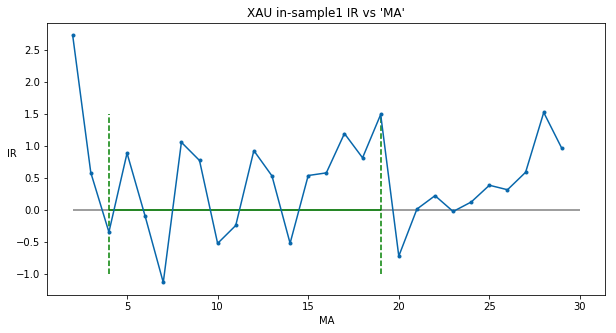

In [6]:
# In sample XAU
plt.figure(figsize=[10,5])
Ir_insample_xau.plot(style='.-')
plt.title("XAU in-sample1 IR vs 'MA'")
plt.hlines(0,2,30,colors='grey')
plt.hlines(0,4,19,colors='g')
plt.vlines(4,-1,1.5,colors='g',linestyles='dashed')
plt.vlines(19,-1,1.5,colors='g',linestyles='dashed')
plt.xlabel('MA')
plt.ylabel('IR',rotation=0)

In [7]:
# Insample2
Ir_insample2_xau = pd.Series(index=range(4,20))
for ma_ in range(4,20):
    ret1, Ir1 ,res1= Strat_MERBO(data=xau_in2, MeanRevertion=True, ma=ma_, identify_period=30, strat_period=30, test_epsilon=2.0, 
                      BreakOut=False, Flow_param=Flow_param_, shift=True, Plot1=False, Plot2=False)
    Ir_insample2_xau.loc[ma_] = Ir1

Text(0,0.5,'IR')

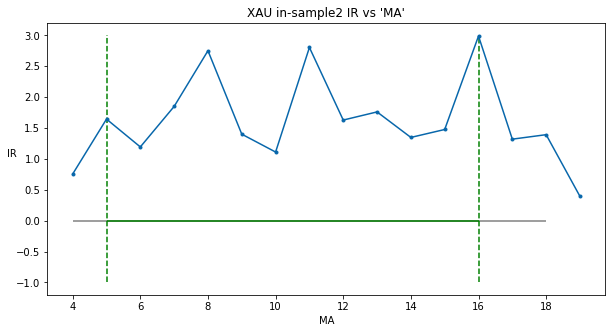

In [8]:
# Insample2 XAU
plt.figure(figsize=[10,5])
Ir_insample2_xau.plot(style='.-')
plt.title("XAU in-sample2 IR vs 'MA'")
plt.hlines(0,4,18,colors='grey')
plt.hlines(0,5,16,colors='g')
plt.vlines(5,-1,3,colors='g',linestyles='dashed')
plt.vlines(16,-1,3,colors='g',linestyles='dashed')
plt.xlabel('MA')
plt.ylabel('IR',rotation=0)

In [9]:
# Insample3
Ir_insample3_xau = pd.Series(index=range(4,17))
for ma_ in range(4,17):
    ret1, Ir1 ,res1= Strat_MERBO(data=xau_in3, MeanRevertion=True, ma=ma_, identify_period=30, strat_period=30, test_epsilon=2.0, 
                      BreakOut=False, Flow_param=Flow_param_, shift=True, Plot1=False, Plot2=False)
    Ir_insample3_xau.loc[ma_] = Ir1

Text(0,0.5,'IR')

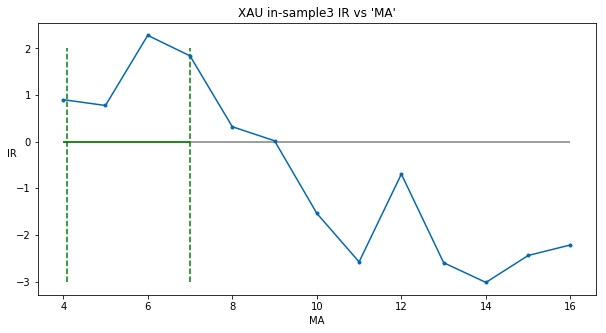

In [10]:
# In-sample3 XAU
plt.figure(figsize=[10,5])
Ir_insample3_xau.plot(style='.-')
plt.title("XAU in-sample3 IR vs 'MA'")
plt.hlines(0,4,16,colors='grey')
plt.hlines(0,4,7,colors='g')
plt.vlines(4.1,-3,2.0,colors='g',linestyles='dashed')
plt.vlines(7,-3,2.0,colors='g',linestyles='dashed')
plt.xlabel('MA')
plt.ylabel('IR',rotation=0)

In [11]:
# Whole in-sample period for xau
Ir_whole_xau = pd.Series(index=range(4,8))
Ir_whole_xau.index = ["MER_ma" + str(x) for x in Ir_whole_xau.index]
ret_whole_xau = pd.DataFrame(columns=Ir_whole_xau.index, index=sorted(list(set(x.date() for x in xau_usd_in.index))))
for ma_ in range(4,8):
    ret1, Ir1 ,res1= Strat_MERBO(data=xau_usd_in, MeanRevertion=True, ma=ma_, identify_period=30, strat_period=30, test_epsilon=2.0, 
                      BreakOut=False, Flow_param=Flow_param_, shift=True, Plot1=False, Plot2=False)    
    Ir_whole_xau.loc[ma_] = Ir1
    ret_whole_xau["MER_ma"+str(ma_)] = ret1

In [12]:
def Strat_performance(ret_df):
    df_whole = ret_df.copy()
    # Cumulative ret and Drawdown 
    cumulative_return = df_whole.cumsum()
    running_max = np.maximum.accumulate(cumulative_return)
    running_max[running_max < 0] = 0
    drawdown = cumulative_return - running_max
    
    fig = plt.figure(figsize=[25, 16])
    ax1 = fig.add_subplot(221)
    cumulative_return.plot(ax=ax1)
    ax1.legend()  
    for strat in drawdown.columns:
        ax1.fill_between(drawdown.index,drawdown[strat],color='grey',alpha=0.2)
      
    ax1.set_title("Cumulative Return & Drawdown",fontsize=20)

    # Annualized Return
    ax2 = fig.add_subplot(222)
    Annualized_return = cumulative_return.iloc[-1,:].apply(lambda x:x * 252 / len(df_whole))
    Annualized_return.plot(kind='bar',ax=ax2,rot=45)
    plt.ylim(0,Annualized_return.max()+0.003)
    ax2.set_title("Annualized Return",fontsize=20)


    # Annualized Volatility
    ax3 = fig.add_subplot(223)
    Annualized_vol = df_whole.std() * np.sqrt(252)
    Annualized_vol.plot(kind='bar',ax=ax3,rot=45)
    plt.ylim(Annualized_vol.min()-0.01,Annualized_vol.max()+0.003)
    ax3.set_title("Annualized Volatility",fontsize=20)


    # Info ratio -- Here is defined as Return/vol
    ax4 = fig.add_subplot(224)
    Information_ratio = Annualized_return / Annualized_vol
    Information_ratio.plot(kind='bar',ax=ax4,rot=45)
    plt.ylim(Information_ratio.min()-0.2,Information_ratio.max()+0.1)
    ax4.set_title("Information Ratio",fontsize=20)

    # Largest 3 DD    
    dd_dic = dict.fromkeys(df_whole.columns,[])
    for colname, col in drawdown.items():
        drawdown_count = []
        tmp = []
        day_fall = 0
        day_recover = 0
        for i in range(len(col)):
            if col[i] < 0:
                tmp.append(col[i])
            if (col[i] == 0) or (i == (len(col) - 1)):
                if (len(tmp) != 0):
                    day_fall = tmp.index(min(tmp)) + 1
                    day_recover = len(tmp) + 1 - day_fall
                    drawdown_count.append([min(tmp),day_fall,day_recover])
                tmp.clear()
        drawdown_count.sort(key=lambda x:x[0])
        dd_dic[colname] = list(itertools.chain.from_iterable(drawdown_count[:3])) ## make it falt

    Mdd = pd.DataFrame(dd_dic).T
    Mdd.columns = ['MDD','drough1','recover1','2DD','drough2','recover2','3DD','drough3','recover3']

    ### Other ratio
    # win, lose ratio
    win_ratio = df_whole[df_whole > 0].count() / len(df_whole)
    #win_ratio = df_whole[df_whole > 0].count() / len(df_whole[df_whole != 0].dropna())
    lose_ratio = df_whole[df_whole < 0].count() / len(df_whole)

    # median daily return, average daily return
    median_return = df_whole.median()
    average_return = df_whole.mean()

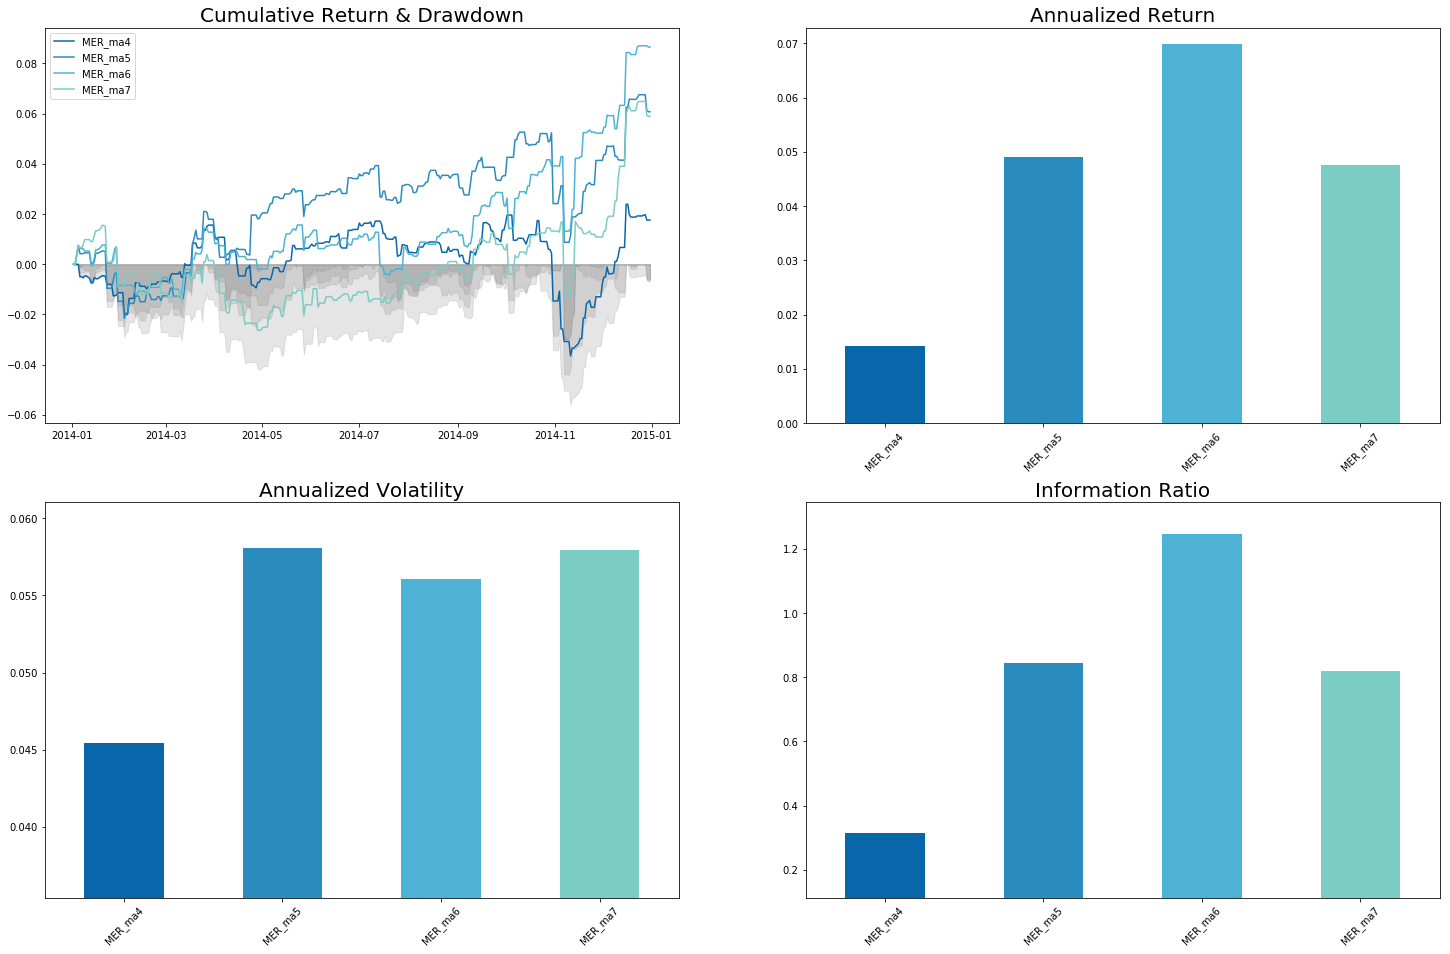

In [13]:
# MER performace whole in-sample period comparison
Strat_performance(ret_whole_xau)

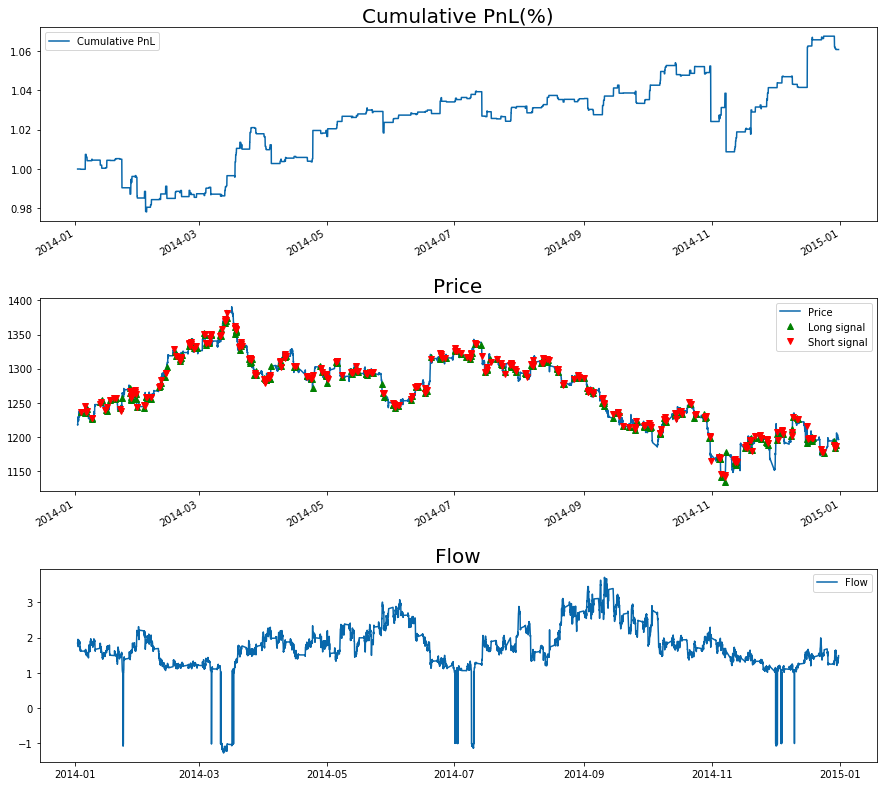

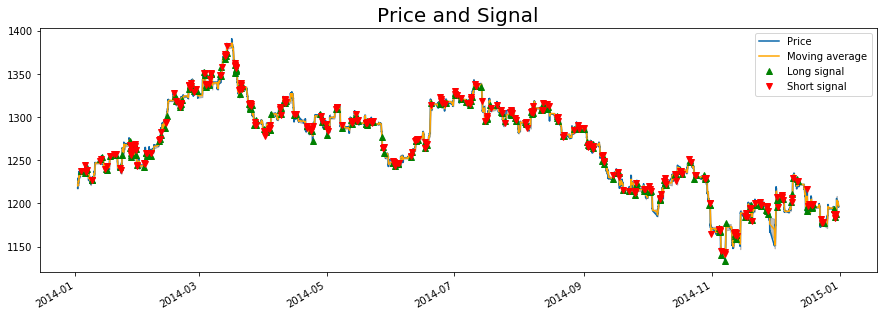

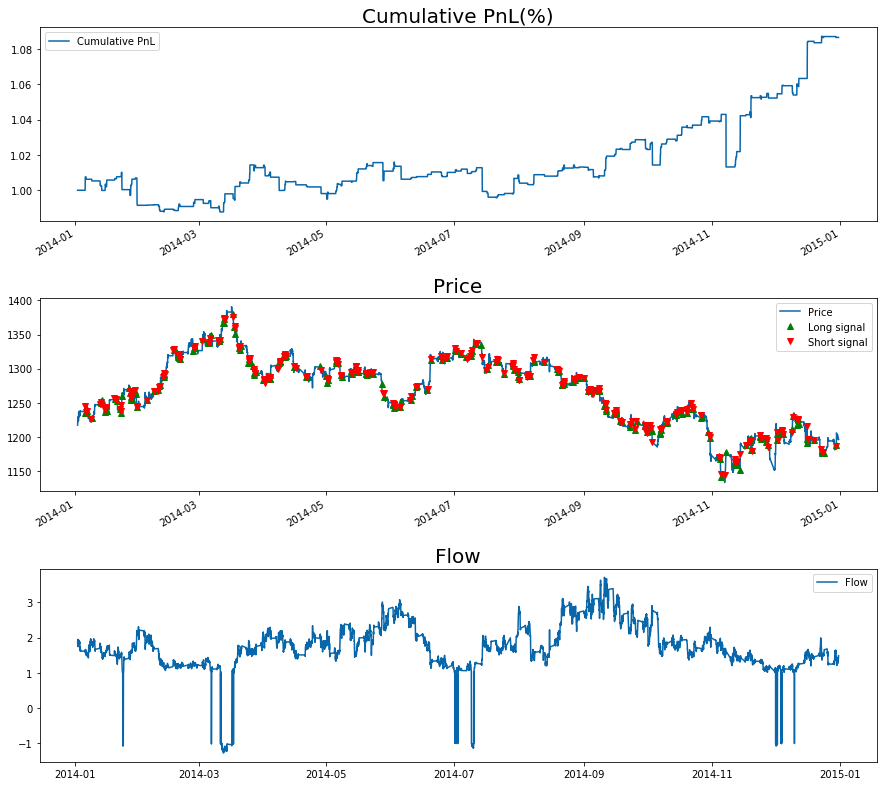

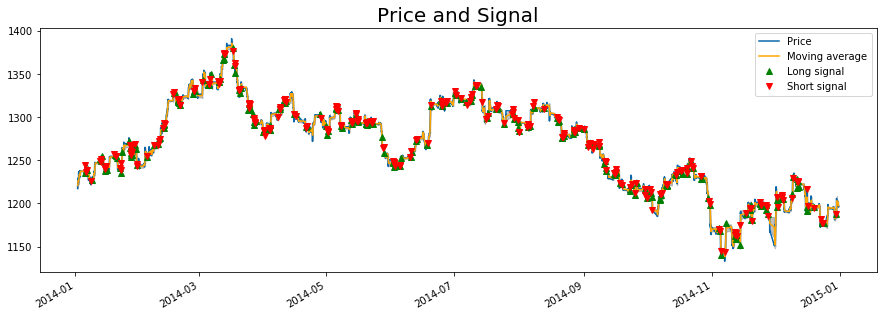

In [14]:
# In-sample MER at ma=5 & ma=6
ret_mer5, Ir_mer5 , res_mer5 = Strat_MERBO(data=xau_usd_in, MeanRevertion=True, ma=5, identify_period=30, strat_period=30, test_epsilon=2.0, 
                      BreakOut=False, Flow_param=Flow_param_, shift=True, Plot1=True, Plot2=True)
ret_mer6, Ir_mer6 , res_mer6 = Strat_MERBO(data=xau_usd_in, MeanRevertion=True, ma=6, identify_period=30, strat_period=30, test_epsilon=2.0, 
                      BreakOut=False, Flow_param=Flow_param_, shift=True, Plot1=True, Plot2=True)

5.358913048313812

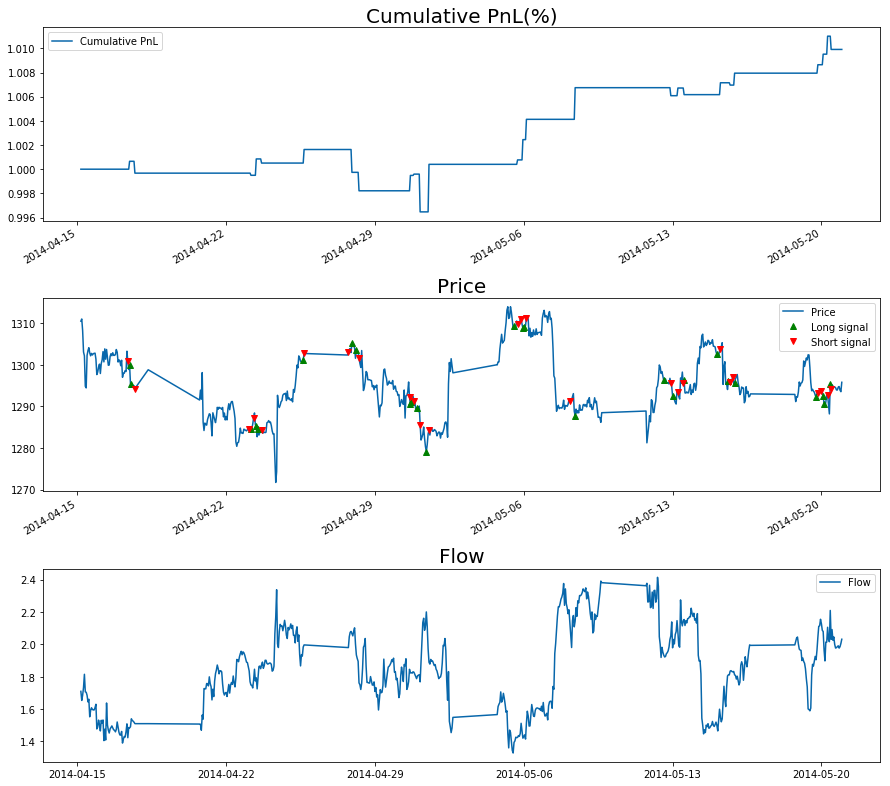

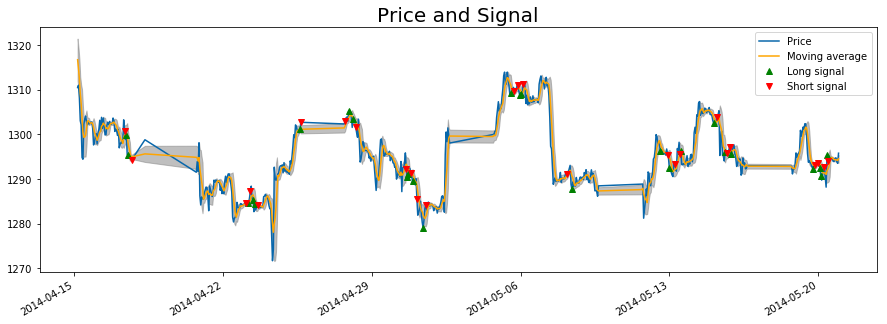

In [15]:
# MER at ma=5 on period['2014-04-15':'2014-05-20']
MER_period = xau_usd_df['2014-04-15':'2014-05-20']
ret_mer5_period, Ir_mer5_period ,result_mer5_period= Strat_MERBO(data=MER_period, MeanRevertion=True, ma=5, identify_period=30, strat_period=30, test_epsilon=2.0, 
                                            BreakOut=False, Flow_param=Flow_param_, shift=True, Plot1=True, Plot2=True)
Ir_mer5_period

# BO
## --- BO Parameters ---- 
BreakOut:          Turn on break out

Flow_param:  First for long threshold, second for short threshold

Text(0.5,1,'Flow')

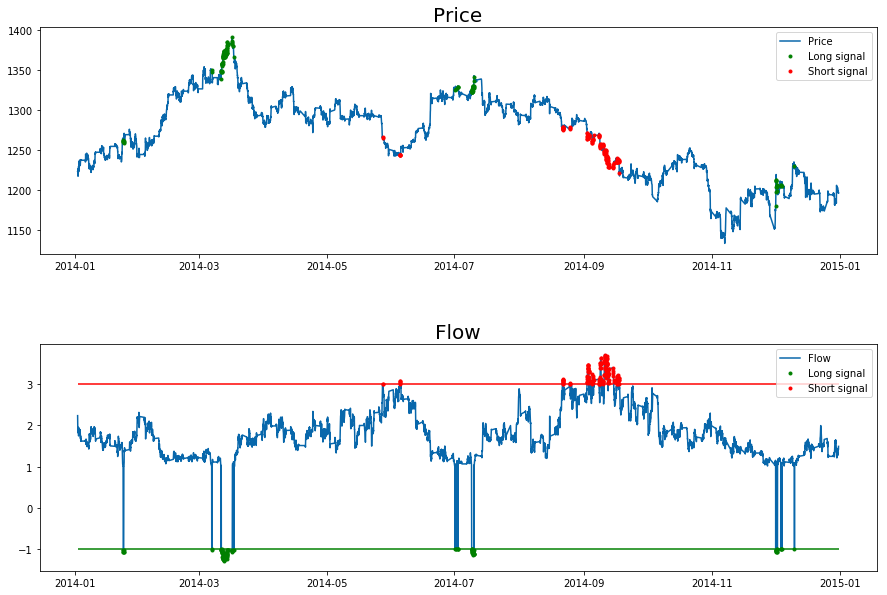

In [16]:
Flow_param_ = [-1, 3.0]
fig = plt.figure(figsize=[15,10])
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
fig.subplots_adjust(hspace=0.4)
# Price
ax1.plot(xau_usd_in.Price)
ax1.plot(xau_usd_in[xau_usd_in.Flow < Flow_param_[0]].Price,'g.')
ax1.plot(xau_usd_in[xau_usd_in.Flow > Flow_param_[1]].Price,'r.')
ax1.legend(["Price","Long signal","Short signal"])
ax1.set_title("Price", fontsize=20)
# Flow
ax2.plot(xau_usd_in.Flow)
ax2.plot(xau_usd_in[xau_usd_in.Flow < Flow_param_[0]].Flow,'g.')
ax2.plot(xau_usd_in[xau_usd_in.Flow > Flow_param_[1]].Flow,'r.')
plt.hlines(y=Flow_param_[0], xmin=xau_usd_in.index[0], xmax=xau_usd_in.index[-1],colors='g')
plt.hlines(y=Flow_param_[1], xmin=xau_usd_in.index[0], xmax=xau_usd_in.index[-1],colors='r')

ax2.legend(["Flow","Long signal","Short signal"])
ax2.set_title("Flow", fontsize=20)

In [17]:
### Apply BO in-sample
Ir_insample_xau_bo = pd.Series()
for up in np.arange(2.0,4.1,0.1):
    print("Trying:"+str(round(up,1)))
    ret_bo, Ir_bo,res_bo = Strat_MERBO(data=xau_insample, MeanRevertion=False, ma=5, identify_period=30, strat_period=30, test_epsilon=2.0, 
                            BreakOut=True, Flow_param=[-1,up], shift=True, Plot1=False, Plot2=False)
    Ir_insample_xau_bo.loc[round(up,1)] = Ir_bo

Trying:2.0
Trying:2.1
Trying:2.2
Trying:2.3
Trying:2.4
Trying:2.5
Trying:2.6
Trying:2.7
Trying:2.8
Trying:2.9
Trying:3.0
Trying:3.1
Trying:3.2
Trying:3.3
Trying:3.4
Trying:3.5
Trying:3.6
Trying:3.7
Trying:3.8
Trying:3.9
Trying:4.0


Text(0,0.5,'IR')

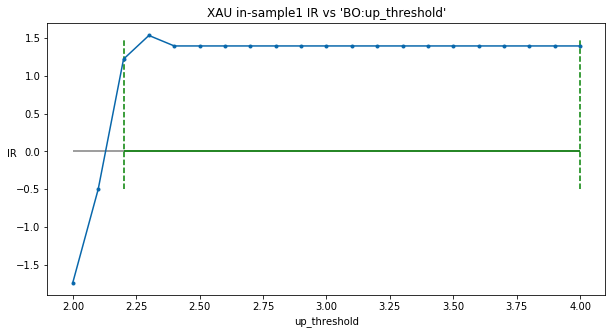

In [18]:
# In sample XAU with BO 
plt.figure(figsize=[10,5])
Ir_insample_xau_bo.plot(style='.-')
plt.title("XAU in-sample1 IR vs 'BO:up_threshold'")
plt.hlines(0,2.0,4.0,colors='grey')
plt.hlines(0,2.2,4.0,colors='g')
plt.vlines(2.2,-0.5,1.5,colors='g',linestyles='dashed')
plt.vlines(4.0,-0.5,1.5,colors='g',linestyles='dashed')
plt.xlabel('up_threshold')
plt.ylabel('IR',rotation=0)

In [19]:
### Apply BO only in-sample2
Ir_in2_xau_bo = pd.Series()
for up in np.arange(2.2,4.1,0.1):
    print("Trying:"+str(round(up,1)))
    ret_bo, Ir_bo , res_bo= Strat_MERBO(data=xau_in2, MeanRevertion=False, ma=5, identify_period=30, strat_period=30, test_epsilon=2.0, 
                            BreakOut=True, Flow_param=[-1,up], shift=True, Plot1=False, Plot2=False)
    Ir_in2_xau_bo.loc[round(up,1)] = Ir_bo

Trying:2.2
Trying:2.3
Trying:2.4
Trying:2.5
Trying:2.6
Trying:2.7
Trying:2.8
Trying:2.9
Trying:3.0
Trying:3.1
Trying:3.2
Trying:3.3
Trying:3.4
Trying:3.5
Trying:3.6
Trying:3.7
Trying:3.8
Trying:3.9
Trying:4.0


Text(0,0.5,'IR')

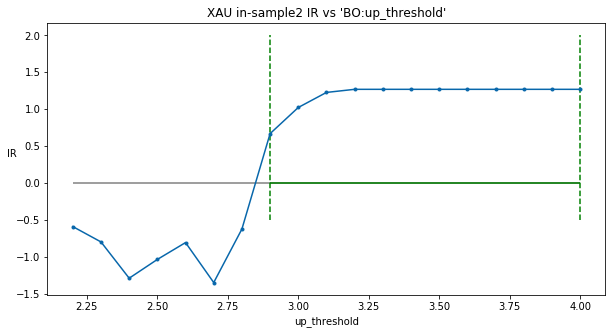

In [20]:
# In-sample2 XAU with BO 
plt.figure(figsize=[10,5])
Ir_in2_xau_bo.plot(style='.-')
plt.title("XAU in-sample2 IR vs 'BO:up_threshold'")
plt.hlines(0.0,2.2,4.0,colors='grey')
plt.hlines(0.0,2.9,4,colors='g')
plt.vlines(2.9,-0.5,2,colors='g',linestyles='dashed')
plt.vlines(4.0,-0.5,2,colors='g',linestyles='dashed')
plt.xlabel('up_threshold')
plt.ylabel('IR',rotation=0)

In [21]:
### Apply BO only in-sample3
Ir_in3_xau_bo = pd.Series()
for up in np.arange(2.9,4.0,0.1):
    print("Trying:"+str(round(up,1)))
    ret_bo, Ir_bo ,res_bo = Strat_MERBO(data=xau_in3, MeanRevertion=False, ma=5, identify_period=30, strat_period=30, test_epsilon=2.0, 
                            BreakOut=True, Flow_param=[-1,up], shift=True, Plot1=False, Plot2=False)
    Ir_in3_xau_bo.loc[round(up,1)] = Ir_bo

Trying:2.9
Trying:3.0
Trying:3.1
Trying:3.2
Trying:3.3
Trying:3.4
Trying:3.5
Trying:3.6
Trying:3.7
Trying:3.8
Trying:3.9


Text(0,0.5,'IR')

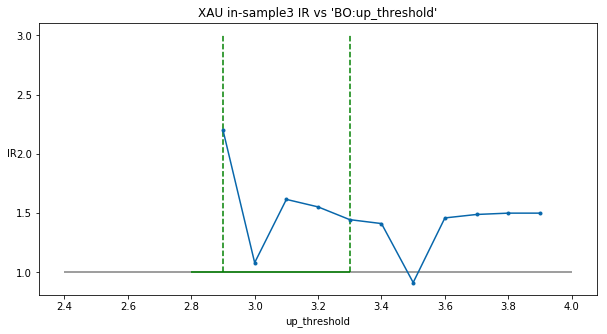

In [22]:
# In sample3 XAU with BO 
plt.figure(figsize=[10,5])
Ir_in3_xau_bo.plot(style='.-')
plt.title("XAU in-sample3 IR vs 'BO:up_threshold'")
plt.hlines(1.0,2.4,4,colors='grey')
plt.hlines(1.0,2.8,3.3,colors='g')
plt.vlines(3.3,1,3,colors='g',linestyles='dashed')
plt.vlines(2.9,1,3,colors='g',linestyles='dashed')
plt.xlabel('up_threshold')
plt.ylabel('IR',rotation=0)

In [23]:
# Whole in-sample period for xau with BO
Ir_wholebo_xau = pd.Series(index = ["BO_up" + str(round(x,1)) for x in np.arange(2.9,3.4,0.1)])
ret_wholebo_xau = pd.DataFrame(columns=Ir_wholebo_xau.index, index=sorted(list(set(x.date() for x in xau_usd_in.index))))
for up_ in np.arange(2.9,3.4,0.1):
    ret1, Ir1 ,res1= Strat_MERBO(data=xau_usd_in, MeanRevertion=False, ma=5, identify_period=30, strat_period=30, test_epsilon=2.0, 
                      BreakOut=True, Flow_param=[-1,up_], shift=True, Plot1=False, Plot2=False)    
    Ir_wholebo_xau.loc[round(up_,1)] = Ir1
    ret_wholebo_xau["BO_up"+str(round(up_,1))] = ret1

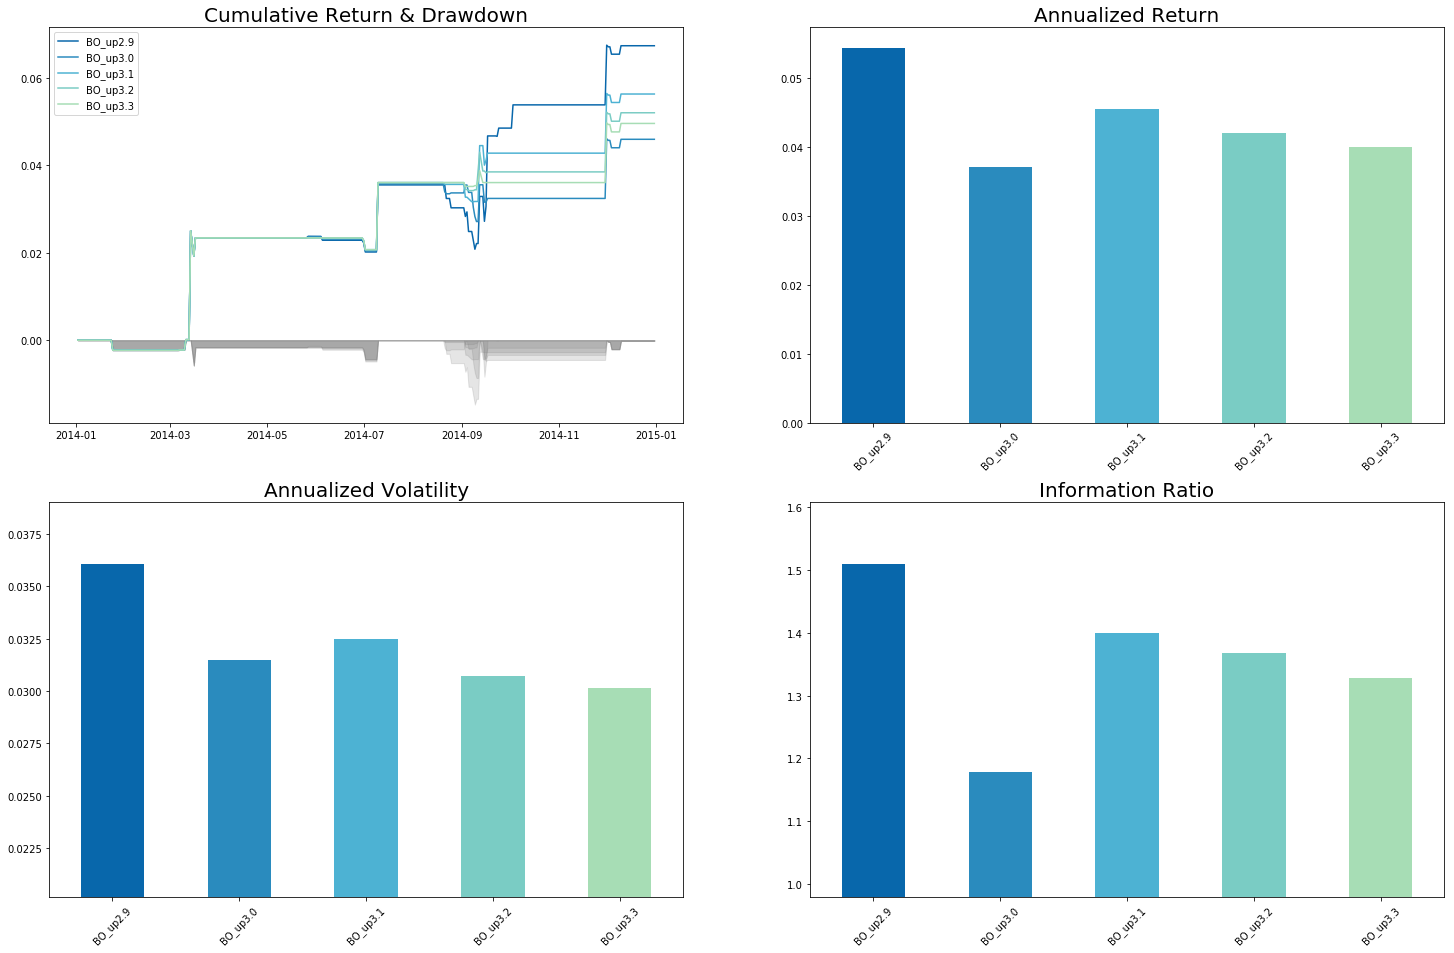

In [24]:
# BO performace comparison
Strat_performance(ret_wholebo_xau)

In [25]:
### Combine them together in insample
Ir_merbo_xau = pd.Series(index = ["MER5BO_up" + str(round(x,1)) for x in np.arange(2.9,3.4,0.1)])
ret_merbo_xau = pd.DataFrame(columns=Ir_merbo_xau.index, index=sorted(list(set(x.date() for x in xau_usd_in.index))))
for up_ in np.arange(2.9,3.4,0.1):
    ret1, Ir1 ,res1= Strat_MERBO(data=xau_usd_in, MeanRevertion=True, ma=5, identify_period=30, strat_period=30, test_epsilon=2.0, 
                      BreakOut=True, Flow_param=[-1,up_], shift=True, Plot1=False, Plot2=False)    
    Ir_merbo_xau.loc[round(up_,1)] = Ir1
    ret_merbo_xau["MER5BO_up"+str(round(up_,1))] = ret1

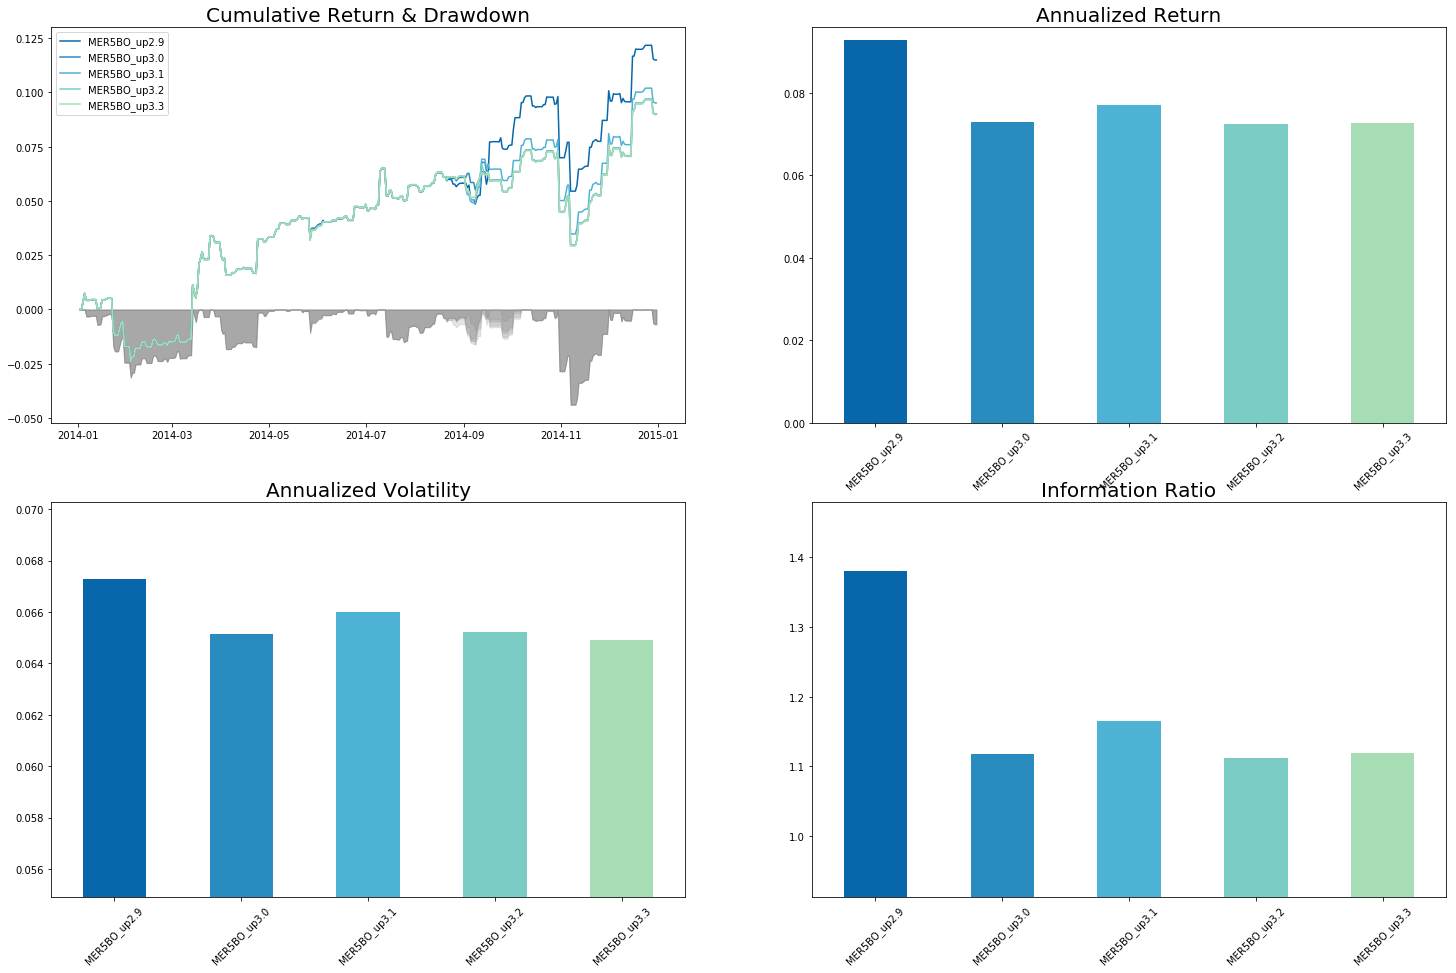

In [26]:
# In-sample MERBO performace comparison
Strat_performance(ret_merbo_xau)

In [27]:
# Now pick up all strats and compare them during in-sample
ret_strats_xau = pd.DataFrame(columns=["MER5BO2.9",'BO2.9','MER5'], index=sorted(list(set(x.date() for x in xau_usd_in.index))))
ret_strats_xau['MER5BO2.9'] = ret_merbo_xau["MER5BO_up2.9"]
ret_strats_xau["BO2.9"] = ret_wholebo_xau["BO_up2.9"]
ret_strats_xau['MER5'] = ret_mer5

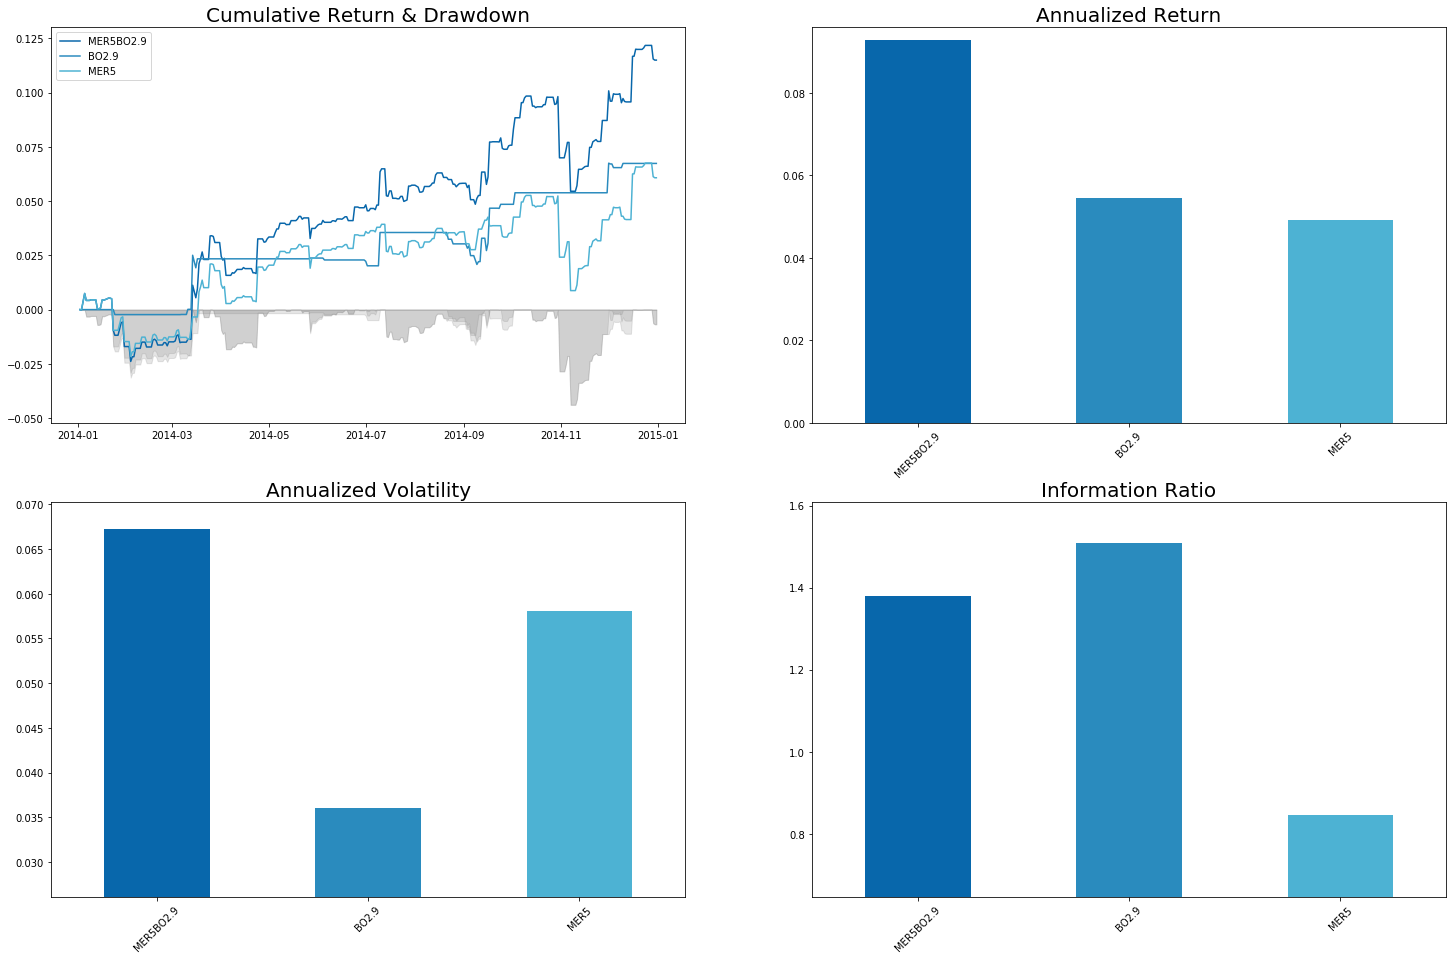

In [28]:
# All 3 strats performace in-sample comparison
Strat_performance(ret_strats_xau)

## Out-of-sample performance

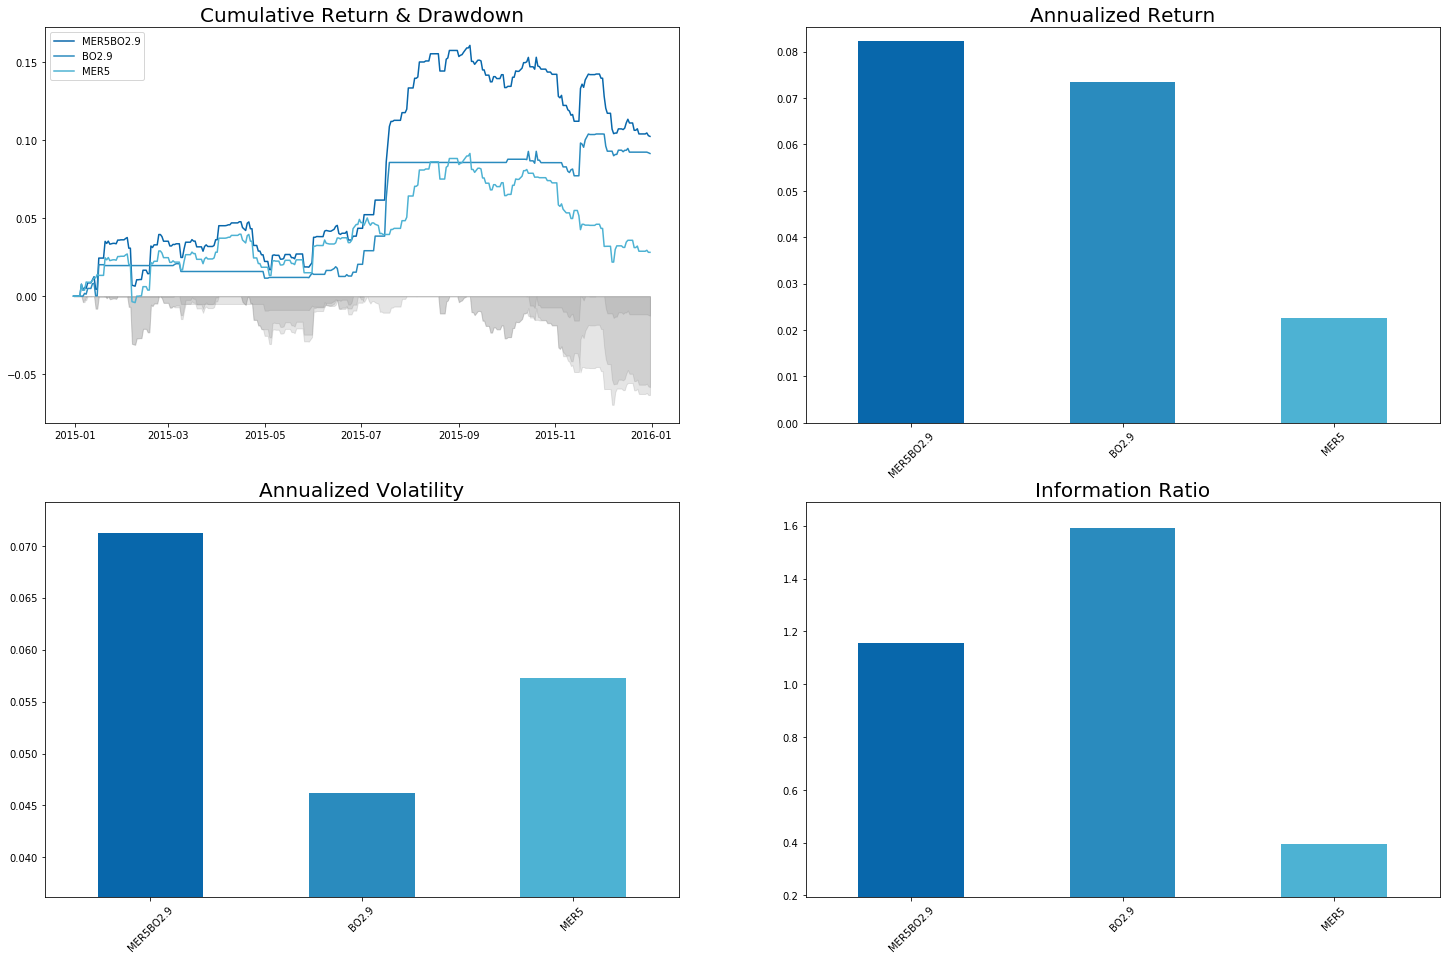

In [29]:
# All 3 strats performace out-of-sample comparison
ret_mer5_out, Ir_mer5_out ,res_mer5_out = Strat_MERBO(data=xau_usd_out, MeanRevertion=True, ma=5, identify_period=30, strat_period=30, test_epsilon=2.0, 
                            BreakOut=False, Flow_param=[-1,2.9], shift=True, Plot1=False, Plot2=False)
ret_bo29_out, Ir_bo29_out,res_mer29_out = Strat_MERBO(data=xau_usd_out, MeanRevertion=False, ma=5, identify_period=30, strat_period=30, test_epsilon=2.0, 
                            BreakOut=True, Flow_param=[-1,2.9], shift=True, Plot1=False, Plot2=False)
ret_mer5_bo29_out, Ir_mer5_bo29_out ,res_mer5_bo29_out= Strat_MERBO(data=xau_usd_out, MeanRevertion=True, ma=5, identify_period=30, strat_period=30, test_epsilon=2.0, 
                            BreakOut=True, Flow_param=[-1,2.9], shift=True, Plot1=False, Plot2=False)
ret_out_xau = pd.DataFrame(columns=["MER5BO2.9",'BO2.9','MER5'], index=sorted(list(set(x.date() for x in xau_usd_out.index))))
ret_out_xau['MER5BO2.9'] = ret_mer5_bo29_out
ret_out_xau["BO2.9"] = ret_bo29_out
ret_out_xau['MER5'] = ret_mer5_out
Strat_performance(ret_out_xau)

1.1544803764118734

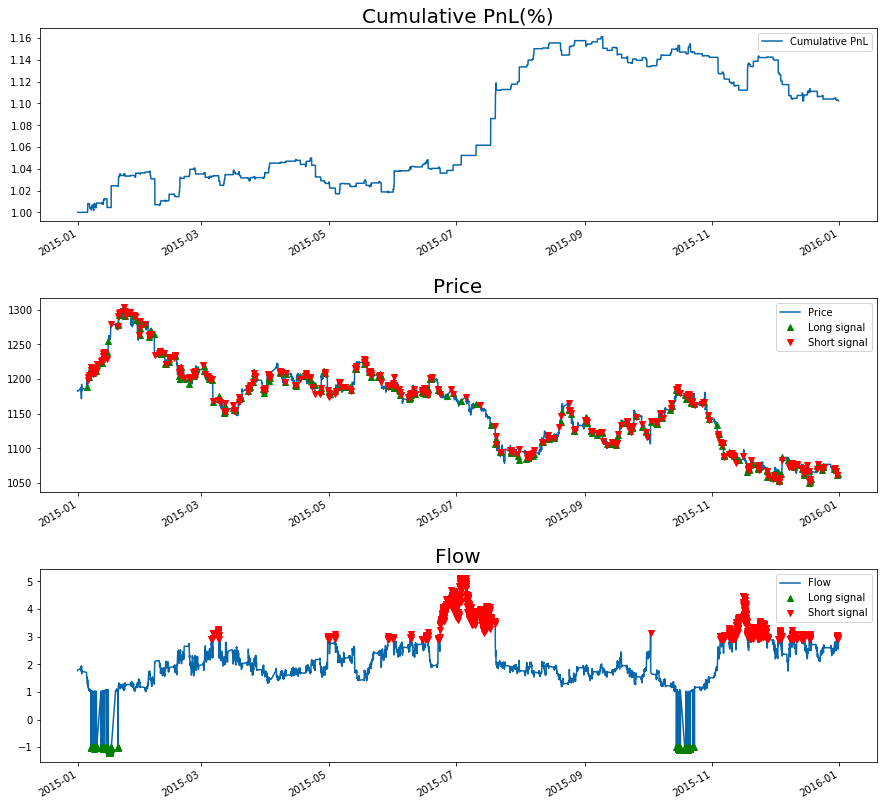

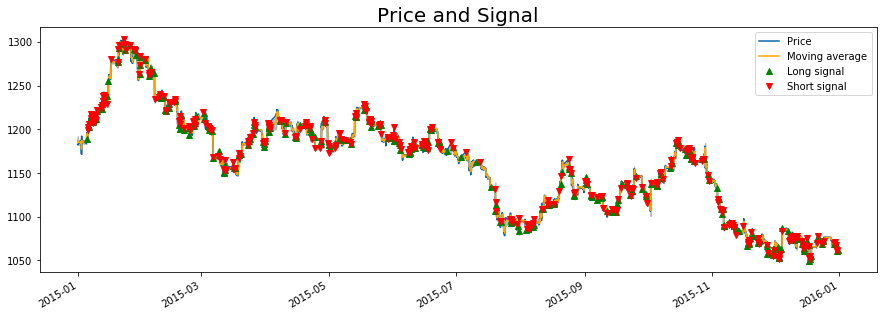

In [30]:
ret_mer5_bo29_out, Ir_mer5_bo29_out ,res_mer5_bo29_out= Strat_MERBO(data=xau_usd_out, MeanRevertion=True, ma=5, identify_period=30, strat_period=30, test_epsilon=2.0, 
                            BreakOut=True, Flow_param=[-1,2.9], shift=True, Plot1=True, Plot2=True)
Ir_mer5_bo29_out

## out of sample performance of our strategy on XAU

In [78]:
res_mer5_bo29_out.astype(float).round(4)

,Number of Trades,Winner ratio,Winner Mean,Winner Median,Loser ratio,Loser Mean,Loser Median,Maximum DrawDown,Information Ratio
result,352.0,0.5597,0.0024,0.0012,0.4659,0.0024,0.0012,-0.0583,1.1545


## Sensitivity

In [32]:
lag_list = [0,1,2,3,4]
lag_IR_result = []
for lag_trial in lag_list :
    lag_IR_result.append(Strat_MERBO(data=xau_usd_out, MeanRevertion=True, ma=5, identify_period=30, strat_period=30, test_epsilon=2.0, 
                            BreakOut=True, Flow_param=[-1,2.9], shift=True, lag = lag_trial, Plot1=False, Plot2=False)[1])

Text(0,0.5,'IR')

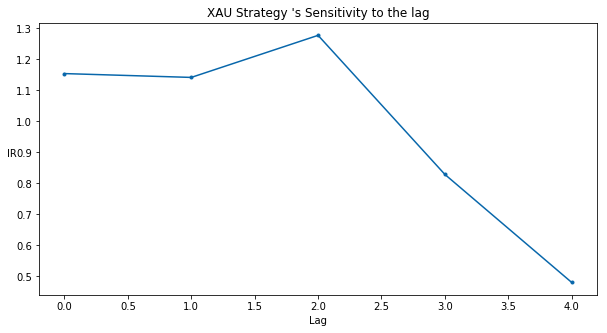

In [33]:
plt.figure(figsize=[10,5])
plt.title("XAU Strategy 's Sensitivity to the lag")
plt.plot(lag_IR_result,'.-')
plt.xlabel('Lag')
plt.ylabel('IR',rotation=0)

In [34]:
BOspread_list = [1,2,3,4]
BOSpread_IR_result = []
for BO_trial in BOspread_list :
    BOSpread_IR_result.append(Strat_MERBO(data=xau_usd_out, MeanRevertion=True, ma=5, identify_period=30, strat_period=30, test_epsilon=2.0, 
                            BreakOut=True, Flow_param=[-1,2.9], shift=True, lag = 0, tc = BO_trial,Plot1=False, Plot2=False)[1])

Text(0,0.5,'IR')

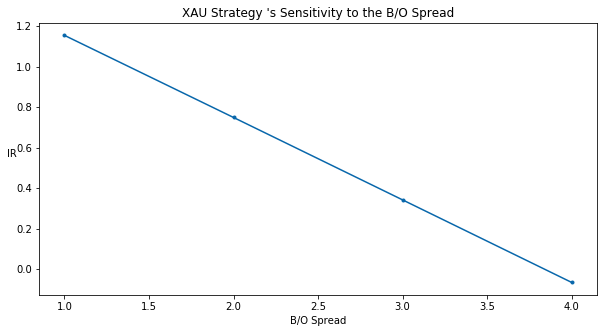

In [35]:
plt.figure(figsize=[10,5])
plt.title("XAU Strategy 's Sensitivity to the B/O Spread")
plt.plot(BOspread_list,BOSpread_IR_result,'.-')
plt.xlabel('B/O Spread')
plt.ylabel('IR',rotation=0)

# Same process on Jpy

### MER

In [36]:
Ir_insample_jpy = pd.Series(index=range(2,40))
for ma_ in range(2,40):
    print("Trying:"+str(ma_))
    ret1, Ir1,res1 = Strat_MERBO(data=jpy_insample, MeanRevertion=True, ma=ma_, identify_period=30, strat_period=30, test_epsilon=2.0, 
                      BreakOut=False, Flow_param=Flow_param_, shift=True, Plot1=False, Plot2=False)
    Ir_insample_jpy.loc[ma_] = Ir1

Trying:2
Trying:3
Trying:4
Trying:5
Trying:6
Trying:7
Trying:8
Trying:9
Trying:10
Trying:11
Trying:12
Trying:13
Trying:14
Trying:15
Trying:16
Trying:17
Trying:18
Trying:19
Trying:20
Trying:21
Trying:22
Trying:23
Trying:24
Trying:25
Trying:26
Trying:27
Trying:28
Trying:29
Trying:30
Trying:31
Trying:32
Trying:33
Trying:34
Trying:35
Trying:36
Trying:37
Trying:38
Trying:39


Text(0,0.5,'IR')

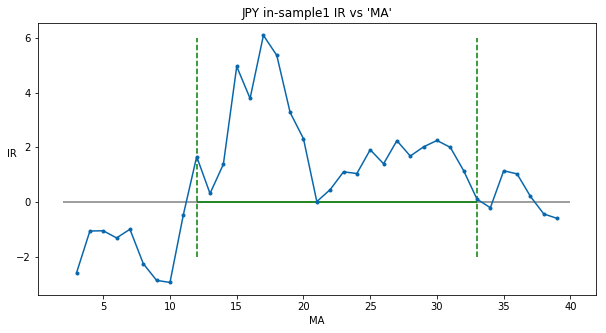

In [37]:
# In sample1 Jpy
plt.figure(figsize=[10,5])
Ir_insample_jpy.plot(style='.-')
plt.title("JPY in-sample1 IR vs 'MA'")
plt.hlines(0,2,40,colors='grey')
plt.hlines(0,12,33,colors='g')
plt.vlines(12,-2,6,colors='g',linestyles='dashed')
plt.vlines(33,-2,6,colors='g',linestyles='dashed')
plt.xlabel('MA')
plt.ylabel('IR',rotation=0)

In [38]:
# Insample2
Ir_insample2_jpy = pd.Series(index=range(12,34))
for ma_ in range(12,34):
    ret1, Ir1 ,res1= Strat_MERBO(data=jpy_in2, MeanRevertion=True, ma=ma_, identify_period=30, strat_period=30, test_epsilon=2.0, 
                      BreakOut=False, Flow_param=Flow_param_, shift=True, Plot1=False, Plot2=False)
    Ir_insample2_jpy.loc[ma_] = Ir1

Text(0,0.5,'IR')

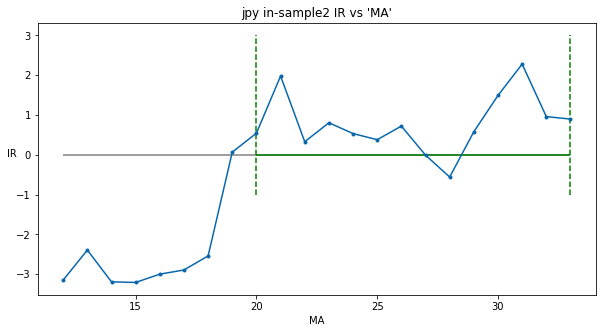

In [39]:
# Insample2 jpy
plt.figure(figsize=[10,5])
Ir_insample2_jpy.plot(style='.-')
plt.title("jpy in-sample2 IR vs 'MA'")
plt.hlines(0,12,33,colors='grey')
plt.hlines(0,20,33,colors='g')
plt.vlines(20,-1,3,colors='g',linestyles='dashed')
plt.vlines(33,-1,3,colors='g',linestyles='dashed')
plt.xlabel('MA')
plt.ylabel('IR',rotation=0)

In [40]:
# Insample3
Ir_insample3_jpy = pd.Series(index=range(20,33))
for ma_ in range(20,33):
    ret1, Ir1 ,res1= Strat_MERBO(data=jpy_in3, MeanRevertion=True, ma=ma_, identify_period=30, strat_period=30, test_epsilon=2.0, 
                      BreakOut=False, Flow_param=Flow_param_, shift=True, Plot1=False, Plot2=False)
    Ir_insample3_jpy.loc[ma_] = Ir1

Text(0,0.5,'IR')

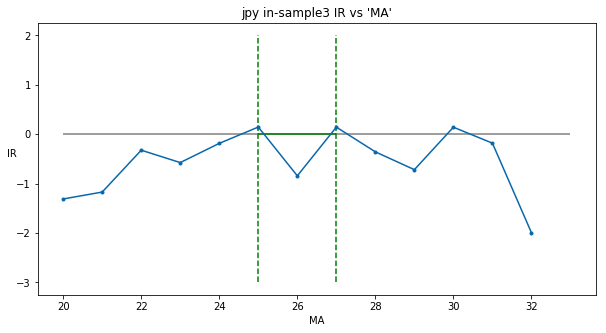

In [41]:
# In-sample3 jpy
plt.figure(figsize=[10,5])
Ir_insample3_jpy.plot(style='.-')
plt.title("jpy in-sample3 IR vs 'MA'")
plt.hlines(0,20,33,colors='grey')
plt.hlines(0,25,27,colors='g')
plt.vlines(25,-3,2.0,colors='g',linestyles='dashed')
plt.vlines(27,-3,2.0,colors='g',linestyles='dashed')
plt.xlabel('MA')
plt.ylabel('IR',rotation=0)

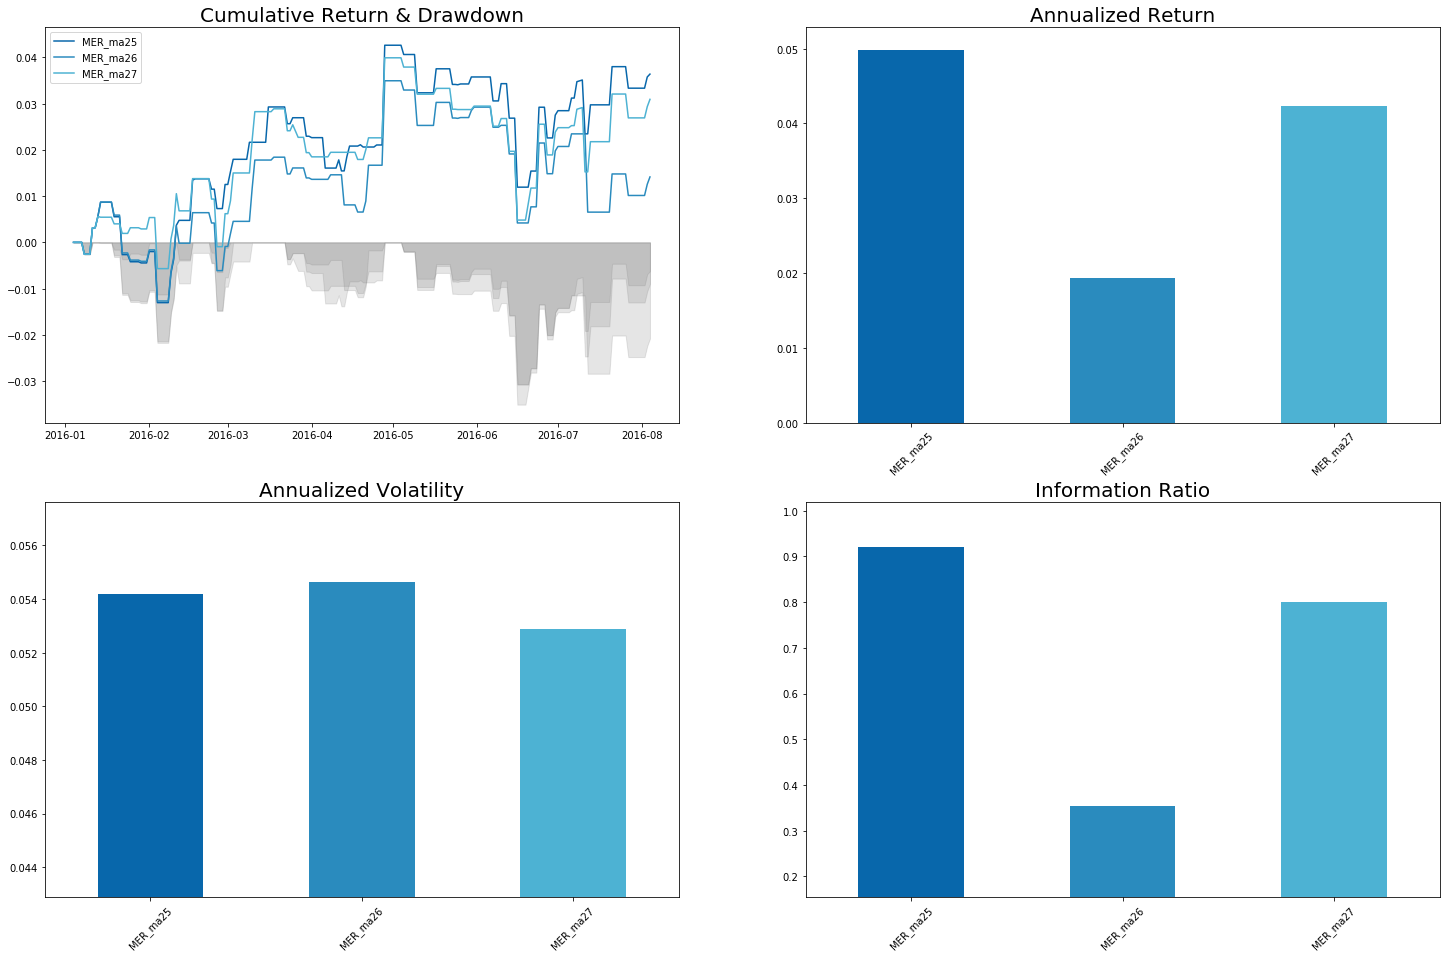

In [42]:
# Whole in-sample period for jpy
Ir_whole_jpy = pd.Series(index=range(25,28))
Ir_whole_jpy.index = ["MER_ma" + str(x) for x in Ir_whole_jpy.index]
ret_whole_jpy = pd.DataFrame(columns=Ir_whole_jpy.index, index=sorted(list(set(x.date() for x in usd_jpy_in.index)))[2:])
for ma_ in range(25,28):
    ret1, Ir1,res1 = Strat_MERBO(data=usd_jpy_in, MeanRevertion=True, ma=ma_, identify_period=30, strat_period=30, test_epsilon=2.0, 
                      BreakOut=False, Flow_param=Flow_param_, shift=True, Plot1=False, Plot2=False)    
    Ir_whole_jpy.loc[ma_] = Ir1
    ret_whole_jpy["MER_ma"+str(ma_)] = ret1

# MER performace whole in-sample period comparison
Strat_performance(ret_whole_jpy)

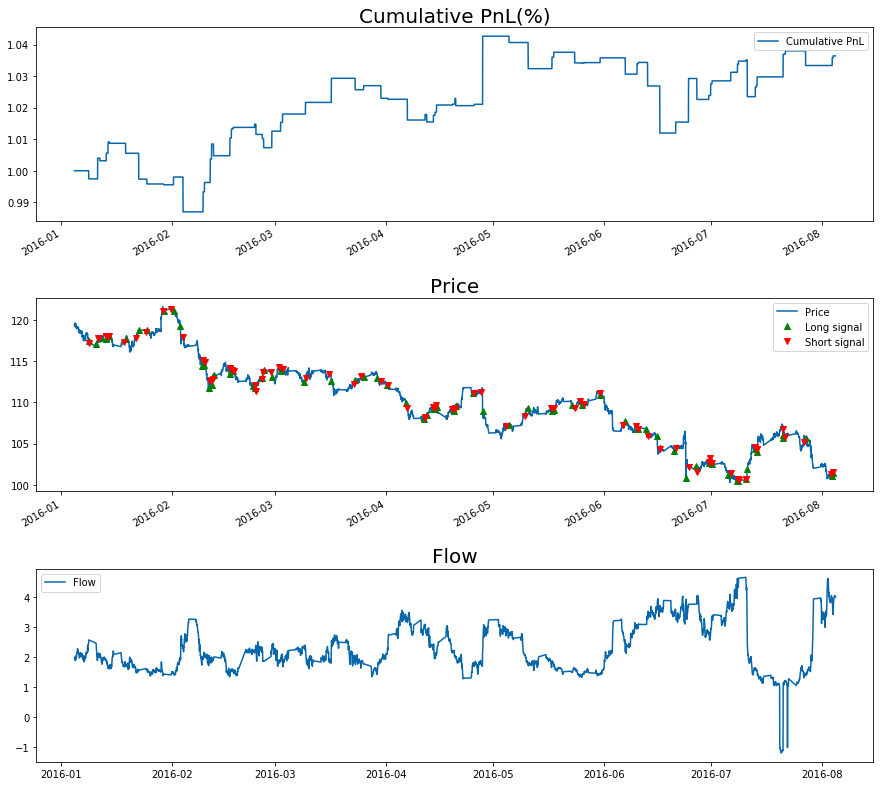

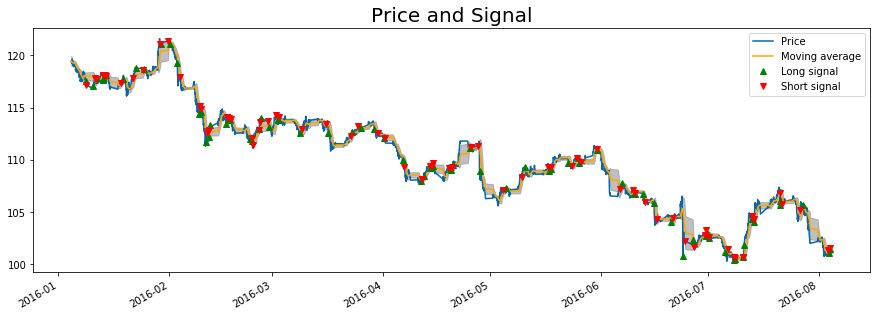

In [43]:
# In-sample MER at ma=25 
ret_mer25, Ir_mer25 ,res_mer25= Strat_MERBO(data=usd_jpy_in, MeanRevertion=True, ma=25, identify_period=30, strat_period=30, test_epsilon=2.0, 
                      BreakOut=False, Flow_param=Flow_param_, shift=True, Plot1=True, Plot2=True)

### BO

Text(0.5,1,'Flow')

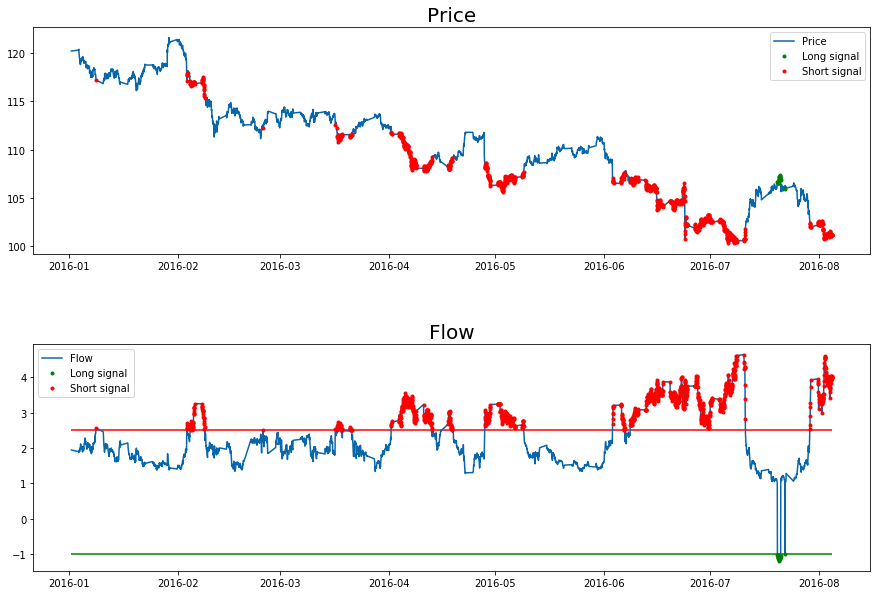

In [44]:
Flow_param_ = [-1, 2.5]
fig = plt.figure(figsize=[15,10])
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
fig.subplots_adjust(hspace=0.4)
# Price
ax1.plot(usd_jpy_in.Price)
ax1.plot(usd_jpy_in[usd_jpy_in.Flow < Flow_param_[0]].Price,'g.')
ax1.plot(usd_jpy_in[usd_jpy_in.Flow > Flow_param_[1]].Price,'r.')
ax1.legend(["Price","Long signal","Short signal"])
ax1.set_title("Price", fontsize=20)
# Flow
ax2.plot(usd_jpy_in.Flow)
ax2.plot(usd_jpy_in[usd_jpy_in.Flow < Flow_param_[0]].Flow,'g.')
ax2.plot(usd_jpy_in[usd_jpy_in.Flow > Flow_param_[1]].Flow,'r.')
plt.hlines(y=Flow_param_[0], xmin=usd_jpy_in.index[0], xmax=usd_jpy_in.index[-1],colors='g')
plt.hlines(y=Flow_param_[1], xmin=usd_jpy_in.index[0], xmax=usd_jpy_in.index[-1],colors='r')
ax2.legend(["Flow","Long signal","Short signal"])
ax2.set_title("Flow", fontsize=20)

In [45]:
### Apply BO in-sample
Ir_insample_jpy_bo = pd.Series()
for up in np.arange(2.0,4.6,0.1):
    print("Trying:"+str(round(up,1)))
    ret_bo, Ir_bo ,res_bo= Strat_MERBO(data=jpy_insample, MeanRevertion=False, ma=5, identify_period=30, strat_period=30, test_epsilon=2.0, 
                            BreakOut=True, Flow_param=[-1,up], shift=True, Plot1=False, Plot2=False)
    Ir_insample_jpy_bo.loc[round(up,1)] = Ir_bo

Trying:2.0
Trying:2.1
Trying:2.2
Trying:2.3
Trying:2.4
Trying:2.5
Trying:2.6
Trying:2.7
Trying:2.8
Trying:2.9
Trying:3.0
Trying:3.1
Trying:3.2
Trying:3.3
Trying:3.4
Trying:3.5
Trying:3.6
Trying:3.7
Trying:3.8
Trying:3.9
Trying:4.0
Trying:4.1
Trying:4.2
Trying:4.3
Trying:4.4
Trying:4.5


Text(0,0.5,'IR')

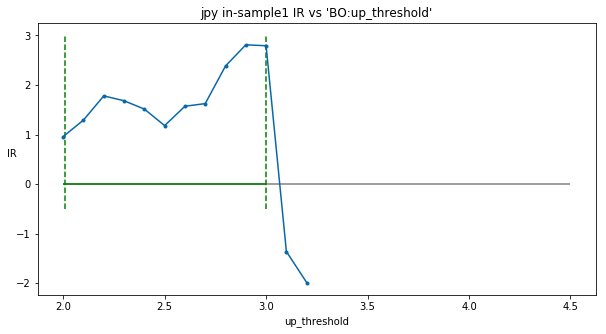

In [46]:
# In sample jpy with BO 
plt.figure(figsize=[10,5])
Ir_insample_jpy_bo.plot(style='.-')
plt.title("jpy in-sample1 IR vs 'BO:up_threshold'")
plt.hlines(0,2.0,4.5,colors='grey')
plt.hlines(0,2.0,3,colors='g')
plt.vlines(2.01,-0.5,3,colors='g',linestyles='dashed')
plt.vlines(3.0,-0.5,3,colors='g',linestyles='dashed')
plt.xlabel('up_threshold')
plt.ylabel('IR',rotation=0)

In [47]:
### Apply BO only in-sample2
Ir_in2_jpy_bo = pd.Series()
for up in np.arange(2.0,3.1,0.1):
    print("Trying:"+str(round(up,1)))
    ret_bo, Ir_bo ,res_bo= Strat_MERBO(data=jpy_in2, MeanRevertion=False, ma=5, identify_period=30, strat_period=30, test_epsilon=2.0, 
                            BreakOut=True, Flow_param=[-1,up], shift=True, Plot1=False, Plot2=False)
    Ir_in2_jpy_bo.loc[round(up,1)] = Ir_bo

Trying:2.0
Trying:2.1
Trying:2.2
Trying:2.3
Trying:2.4
Trying:2.5
Trying:2.6
Trying:2.7
Trying:2.8
Trying:2.9
Trying:3.0


Text(0,0.5,'IR')

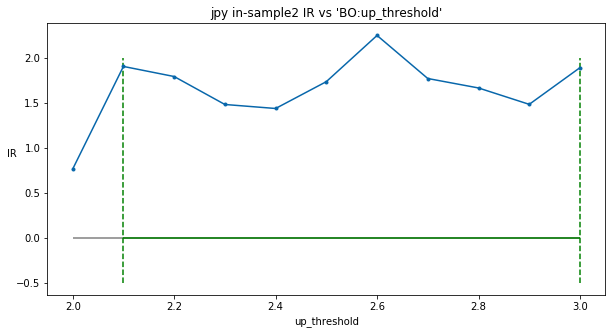

In [48]:
# In-sample2 jpy with BO 
plt.figure(figsize=[10,5])
Ir_in2_jpy_bo.plot(style='.-')
plt.title("jpy in-sample2 IR vs 'BO:up_threshold'")
plt.hlines(0.0,2.0,3.0,colors='grey')
plt.hlines(0.0,2.1,3,colors='g')
plt.vlines(2.1,-0.5,2,colors='g',linestyles='dashed')
plt.vlines(3.0,-0.5,2,colors='g',linestyles='dashed')
plt.xlabel('up_threshold')
plt.ylabel('IR',rotation=0)

In [49]:
### Apply BO only in-sample3
Ir_in3_jpy_bo = pd.Series()
for up in np.arange(2.1,3.1,0.1):
    print("Trying:"+str(round(up,1)))
    ret_bo, Ir_bo ,res_bo= Strat_MERBO(data=jpy_in3, MeanRevertion=False, ma=5, identify_period=30, strat_period=30, test_epsilon=2.0, 
                            BreakOut=True, Flow_param=[-1,up], shift=True, Plot1=False, Plot2=False)
    Ir_in3_jpy_bo.loc[round(up,1)] = Ir_bo

Trying:2.1
Trying:2.2
Trying:2.3
Trying:2.4
Trying:2.5
Trying:2.6
Trying:2.7
Trying:2.8
Trying:2.9
Trying:3.0


Text(0,0.5,'IR')

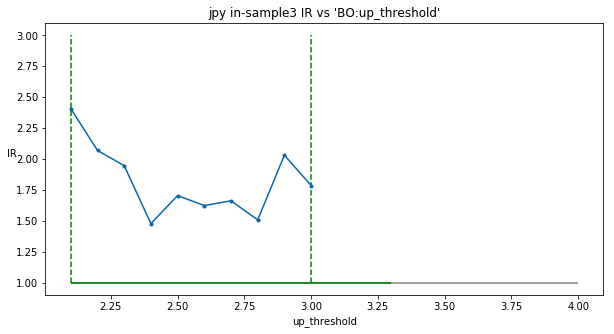

In [50]:
# In sample3 jpy with BO 
plt.figure(figsize=[10,5])
Ir_in3_jpy_bo.plot(style='.-')
plt.title("jpy in-sample3 IR vs 'BO:up_threshold'")
plt.hlines(1.0,2.1,4,colors='grey')
plt.hlines(1.0,2.1,3.3,colors='g')
plt.vlines(2.101,1,3,colors='g',linestyles='dashed')
plt.vlines(3,1,3,colors='g',linestyles='dashed')
plt.xlabel('up_threshold')
plt.ylabel('IR',rotation=0)

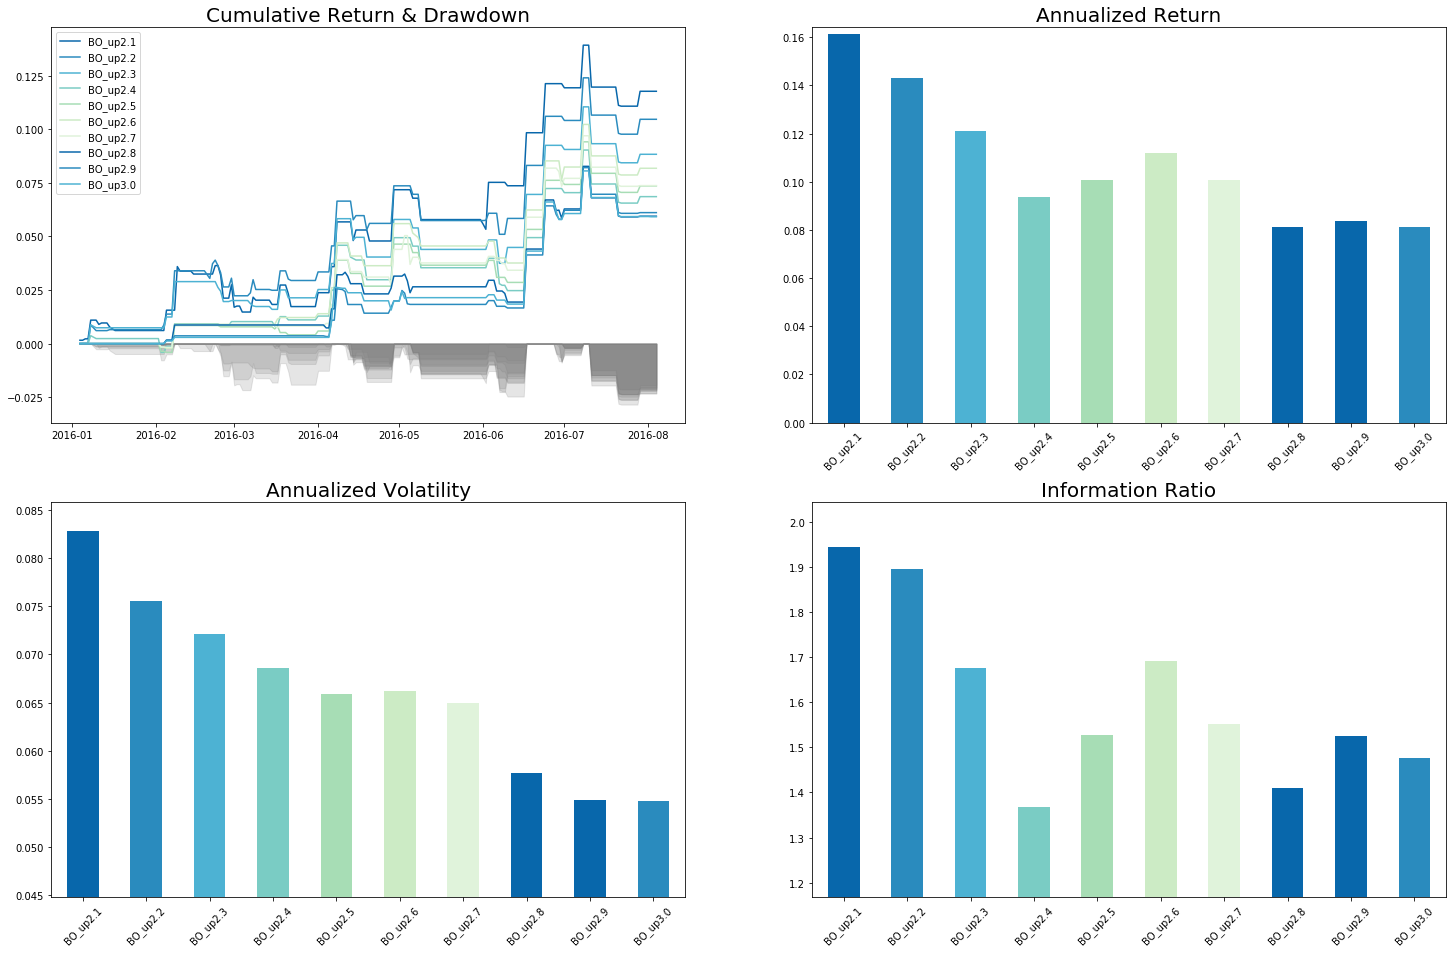

In [51]:
# Whole in-sample period for jpy with BO
Ir_wholebo_jpy = pd.Series(index = ["BO_up" + str(round(x,1)) for x in np.arange(2.1,3.1,0.1)])
ret_wholebo_jpy = pd.DataFrame(columns=Ir_wholebo_jpy.index, index=sorted(list(set(x.date() for x in usd_jpy_in.index)))[2:])
for up_ in np.arange(2.1,3.1,0.1):
    ret1, Ir1 ,res1= Strat_MERBO(data=usd_jpy_in, MeanRevertion=False, ma=5, identify_period=30, strat_period=30, test_epsilon=2.0, 
                      BreakOut=True, Flow_param=[-1,up_], shift=True, Plot1=False, Plot2=False)    
    Ir_wholebo_jpy.loc[round(up_,1)] = Ir1
    ret_wholebo_jpy["BO_up"+str(round(up_,1))] = ret1
# BO performace comparison
Strat_performance(ret_wholebo_jpy)

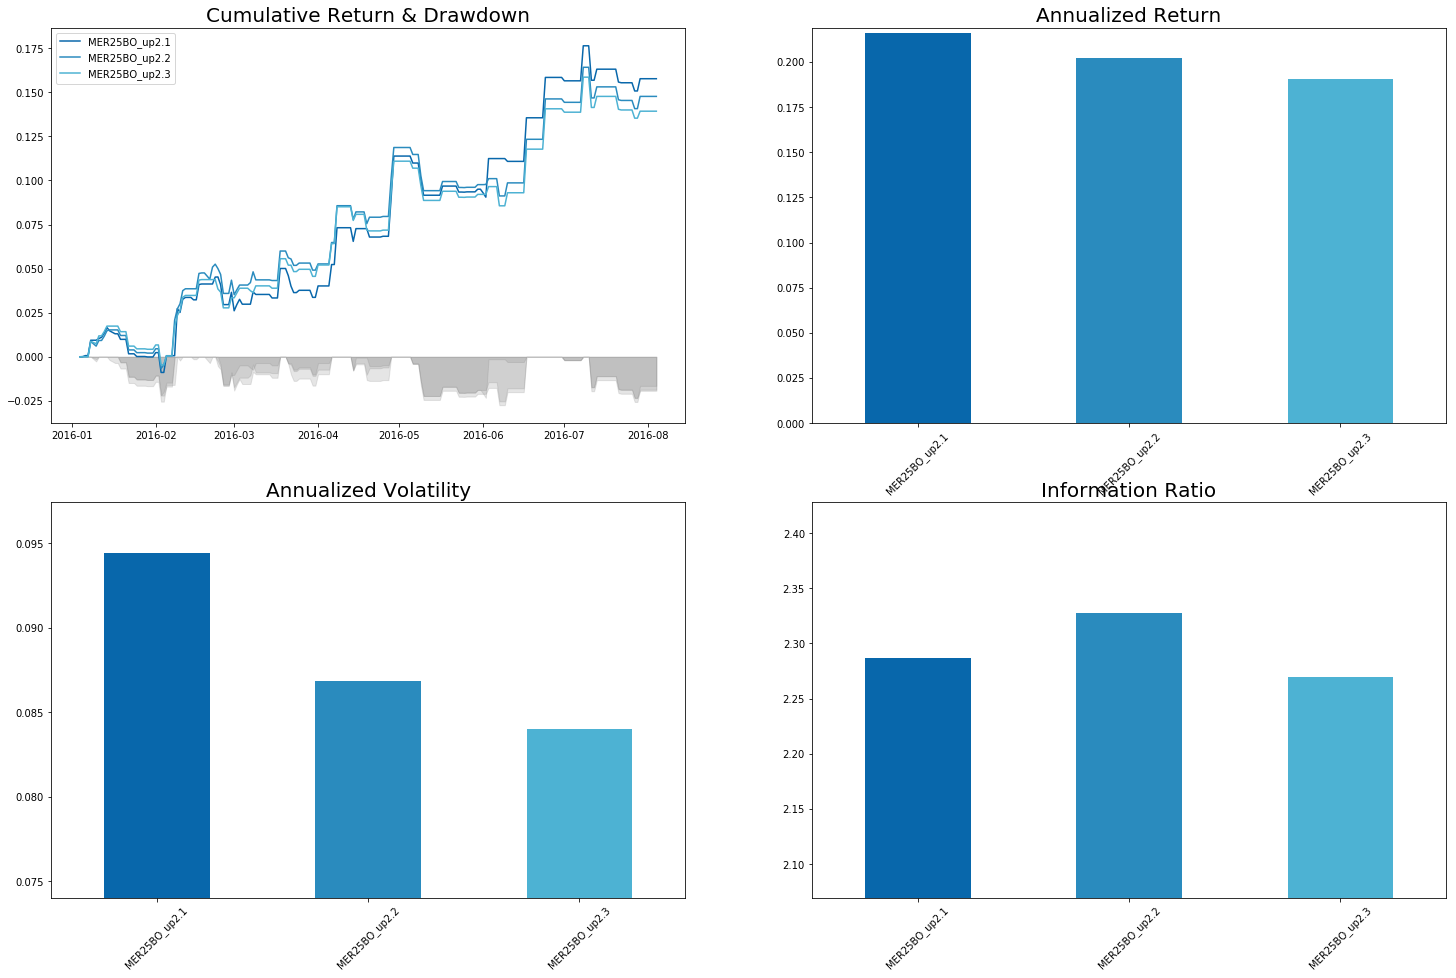

In [52]:
### Combine them together in insample
Ir_merbo_jpy = pd.Series(index = ["MER25BO_up" + str(round(x,1)) for x in np.arange(2.1,2.4,0.1)])
ret_merbo_jpy = pd.DataFrame(columns=Ir_merbo_jpy.index, index=sorted(list(set(x.date() for x in usd_jpy_in.index)))[2:])
for up_ in np.arange(2.1,2.4,0.1):
    ret1, Ir1 ,res1= Strat_MERBO(data=usd_jpy_in, MeanRevertion=True, ma=25, identify_period=30, strat_period=30, test_epsilon=2.0, 
                      BreakOut=True, Flow_param=[-1,up_], shift=True, Plot1=False, Plot2=False)    
    Ir_merbo_jpy.loc[round(up_,1)] = Ir1
    ret_merbo_jpy["MER25BO_up"+str(round(up_,1))] = ret1

# In-sample MERBO performace comparison
Strat_performance(ret_merbo_jpy)

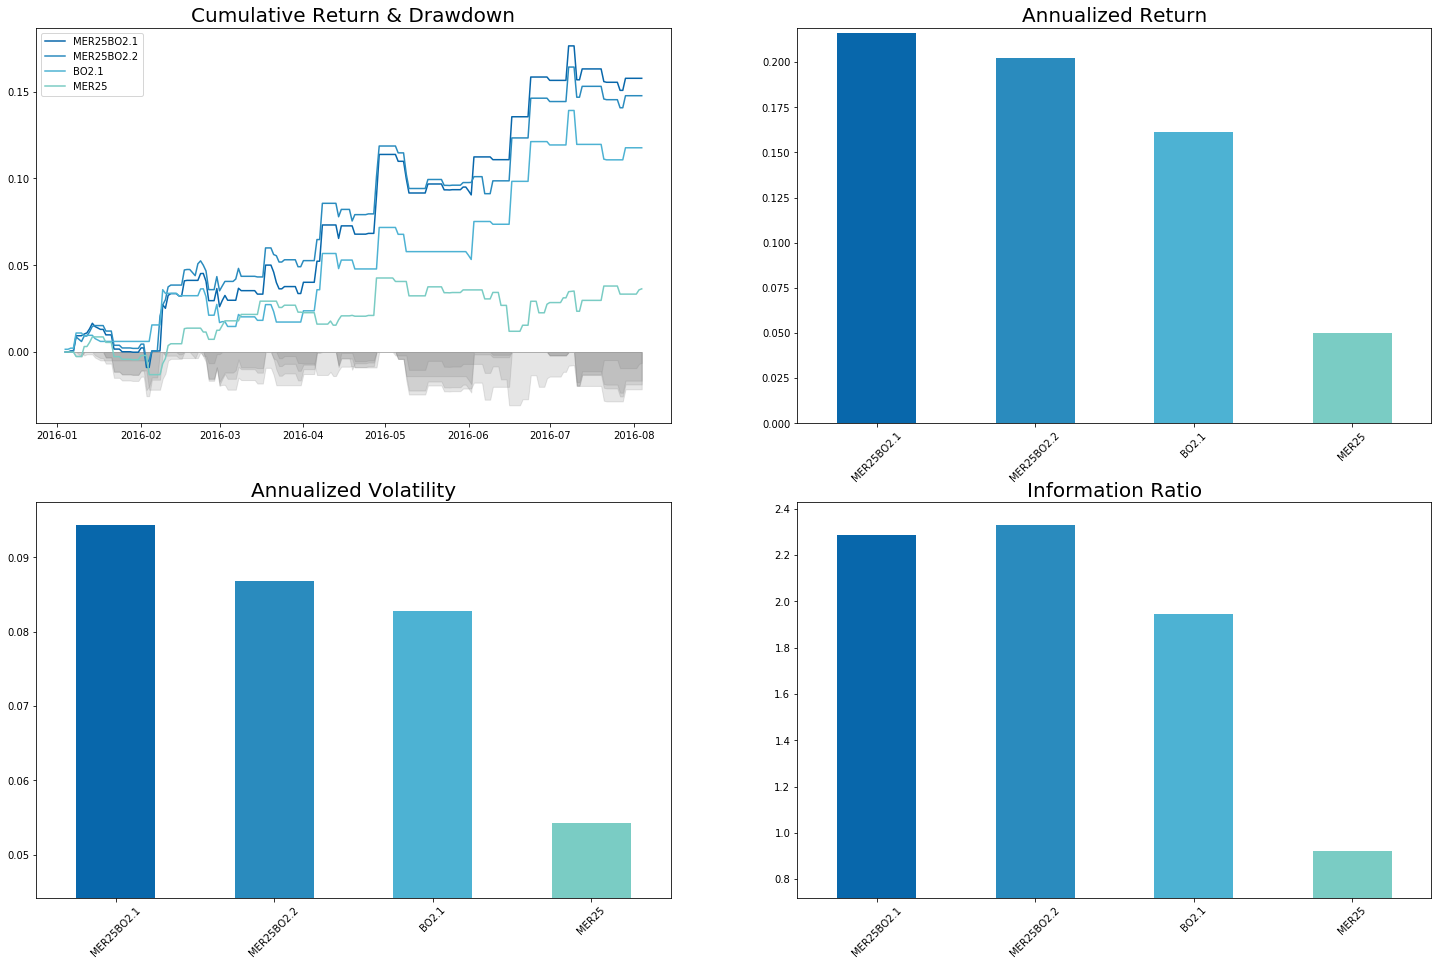

In [53]:
# Now pick up all strats and compare them during in-sample
ret_strats_jpy = pd.DataFrame(columns=["MER25BO2.1","MER25BO2.2",'BO2.1','MER25'], index=sorted(list(set(x.date() for x in usd_jpy_in.index)))[2:])
ret_strats_jpy[['MER25BO2.1',"MER25BO2.2"]] = ret_merbo_jpy[["MER25BO_up2.1","MER25BO_up2.2"]]
ret_strats_jpy["BO2.1"] = ret_wholebo_jpy["BO_up2.1"]
ret_strats_jpy['MER25'] = ret_mer25

# All 4 strats performace in-sample comparison
Strat_performance(ret_strats_jpy)

ValueError: arrays must all be same length

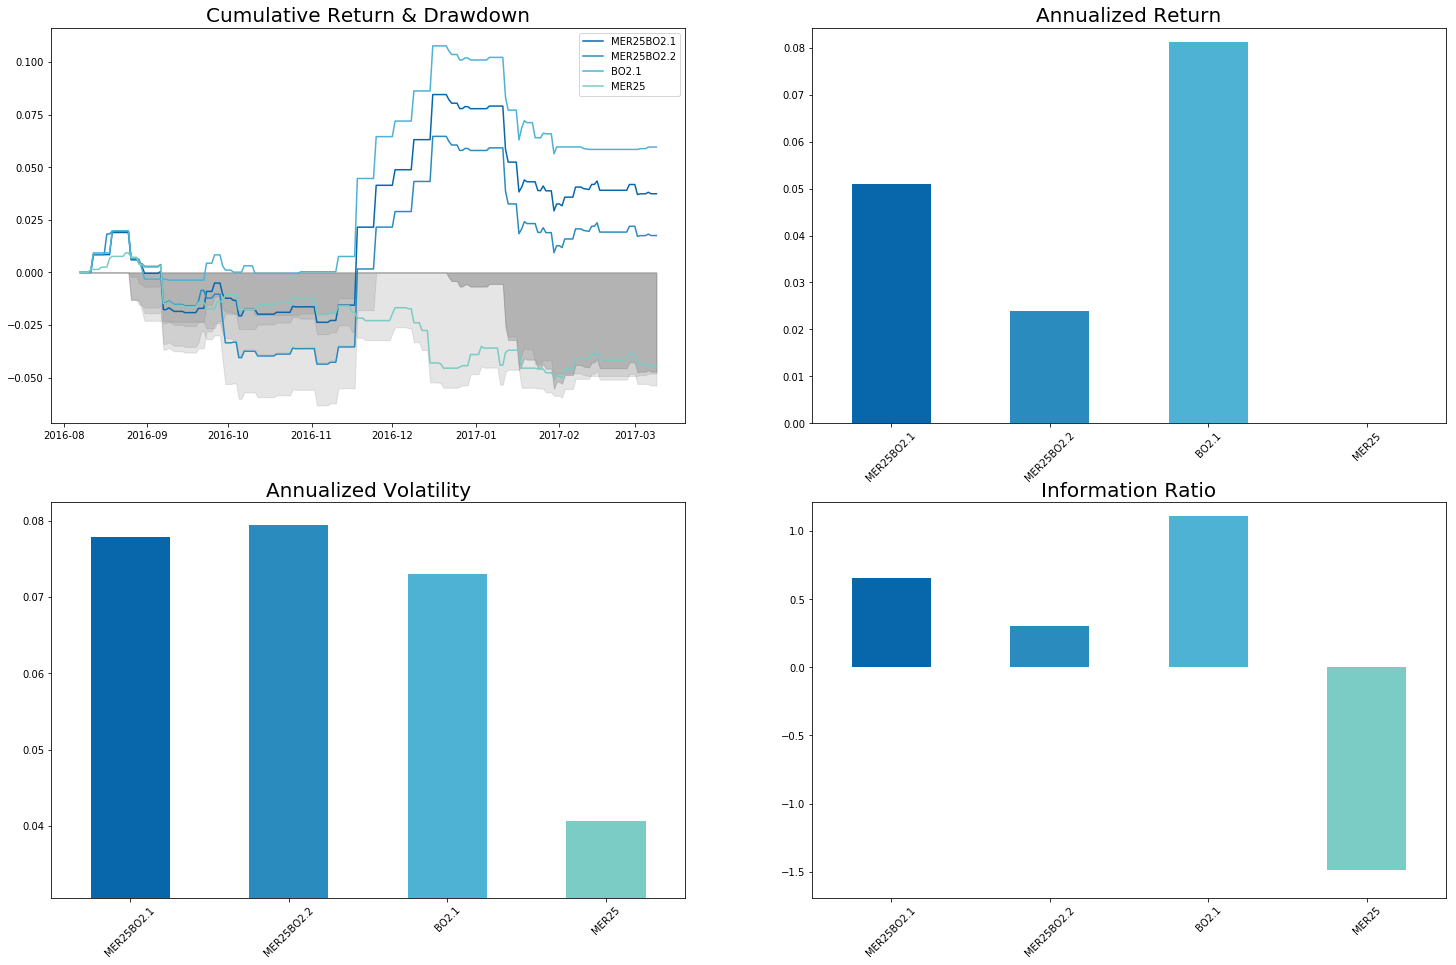

In [54]:
# All 4 strats performace out-of-sample comparison
ret_mer25_out, Ir_mer25_out, res_mer25_out= Strat_MERBO(data=usd_jpy_out, MeanRevertion=True, ma=25, identify_period=30, strat_period=30, test_epsilon=2.0, 
                            BreakOut=False, Flow_param=[-1,2.1], shift=True, Plot1=False, Plot2=False)
ret_bo21_out, Ir_bo21_out ,res_bo21_out= Strat_MERBO(data=usd_jpy_out, MeanRevertion=False, ma=25, identify_period=30, strat_period=30, test_epsilon=2.0, 
                            BreakOut=True, Flow_param=[-1,2.1], shift=True, Plot1=False, Plot2=False)
ret_mer25_bo21_out, Ir_mer25_bo21_out,res_mer25_bo21_out = Strat_MERBO(data=usd_jpy_out, MeanRevertion=True, ma=25, identify_period=30, strat_period=30, test_epsilon=2.0, 
                            BreakOut=True, Flow_param=[-1,2.1], shift=True, Plot1=False, Plot2=False)
ret_mer25_bo22_out, Ir_mer25_bo22_out,res_mer25_bo22_out = Strat_MERBO(data=usd_jpy_out, MeanRevertion=True, ma=25, identify_period=30, strat_period=30, test_epsilon=2.0, 
                            BreakOut=True, Flow_param=[-1,2.2], shift=True, Plot1=False, Plot2=False)
ret_out_jpy = pd.DataFrame(columns=["MER25BO2.1","MER25BO2.2",'BO2.1','MER25'], index=sorted(list(set(x.date() for x in usd_jpy_out.index)))[2:])
ret_out_jpy['MER25BO2.1'] = ret_mer25_bo21_out
ret_out_jpy['MER25BO2.2'] = ret_mer25_bo22_out
ret_out_jpy["BO2.1"] = ret_bo21_out
ret_out_jpy['MER25'] = ret_mer25_out
Strat_performance(ret_out_jpy)

### So for JPY, BO-only has the best out-of-sample performance
### while MER performs bad out sample

0.9982102246484301

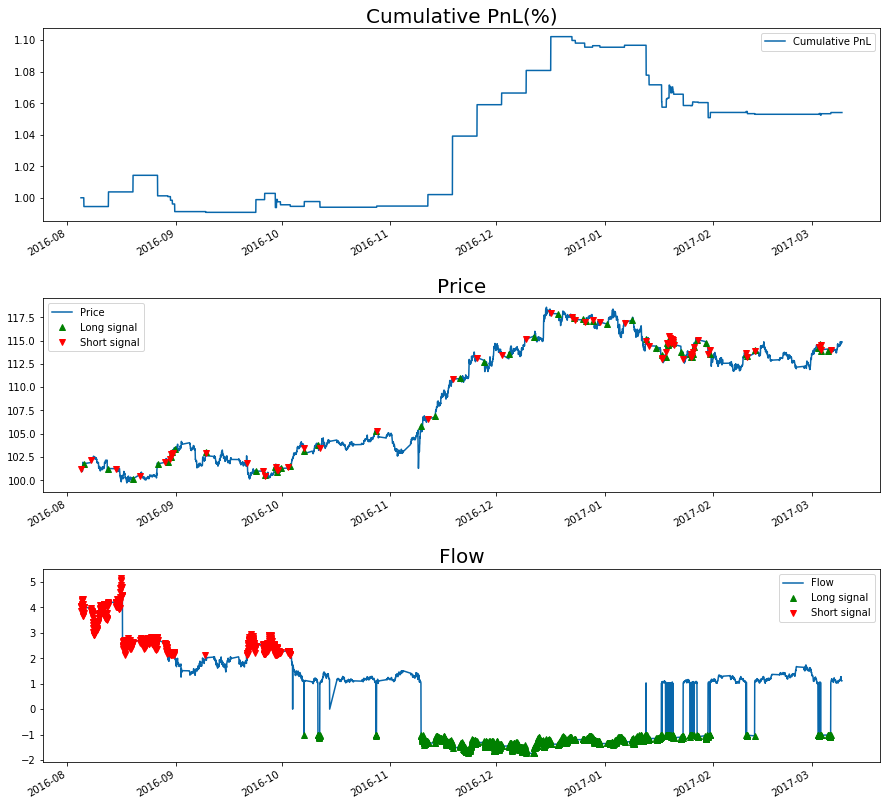

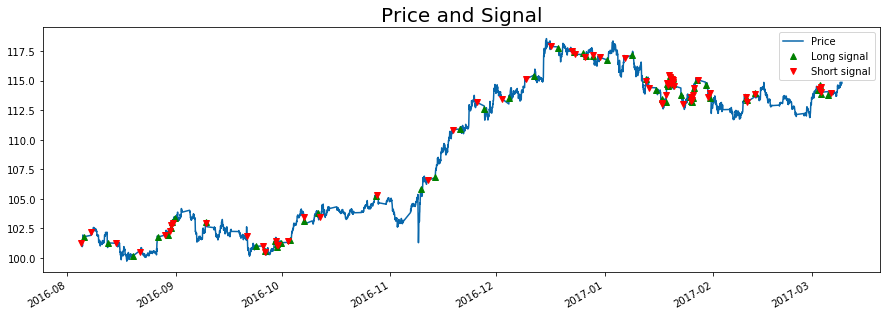

In [62]:
ret_bo21_out, Ir_bo21_out ,res_bo21_out= Strat_MERBO(data=usd_jpy_out, MeanRevertion=False, ma=25, identify_period=30, strat_period=30, test_epsilon=2.0, 
                            BreakOut=True, Flow_param=[-1,2.1], shift=True, Plot1=True, Plot2=True)
Ir_bo21_out

## out of sample performance of our strategy on JPY

In [77]:
res_bo21_out = res_bo21_out.round(decimals = 4)
res_bo21_out.astype(float).round(4)

,Number of Trades,Winner ratio,Winner Mean,Winner Median,Loser ratio,Loser Mean,Loser Median,Maximum DrawDown,Information Ratio
result,61.0,0.459,0.0063,0.0035,0.541,0.0063,0.0035,-0.0514,0.9982


In [57]:
lag_list = [0,1,2,3,4]
lag_IR_result = []
for lag_trial in lag_list :
    lag_IR_result.append(Strat_MERBO(data=usd_jpy_out, MeanRevertion=False, ma=25, identify_period=30, strat_period=30, test_epsilon=2.0, 
                            BreakOut=True, Flow_param=[-1,2.1], shift=True, lag = lag_trial, Plot1=False, Plot2=False)[1])

Text(0,0.5,'IR')

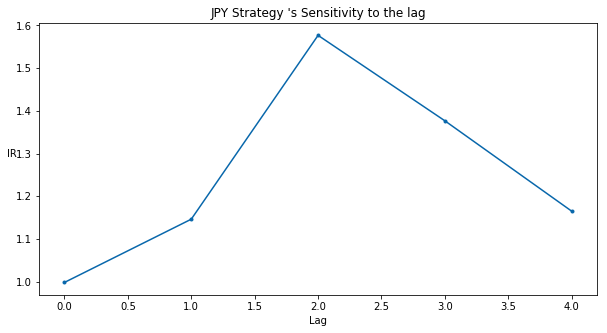

In [58]:
plt.figure(figsize=[10,5])
plt.title("JPY Strategy 's Sensitivity to the lag")
plt.plot(lag_IR_result,'.-')
plt.xlabel('Lag')
plt.ylabel('IR',rotation=0)

In [59]:
BOspread_list = [1,2,3,4]
BOSpread_IR_result = []
for BO_trial in BOspread_list :
    BOSpread_IR_result.append(Strat_MERBO(data=usd_jpy_out, MeanRevertion=False, ma=25, identify_period=30, strat_period=30, test_epsilon=2.0, 
                            BreakOut=True, Flow_param=[-1,2.1], shift=True, lag = 0, tc = BO_trial,Plot1=False, Plot2=False)[1])

Text(0,0.5,'IR')

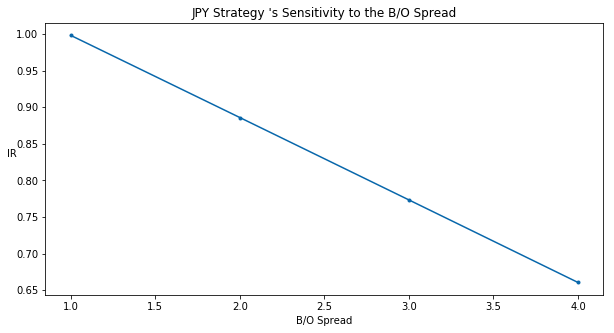

In [60]:
plt.figure(figsize=[10,5])
plt.title("JPY Strategy 's Sensitivity to the B/O Spread")
plt.plot(BOspread_list,BOSpread_IR_result,'.-')
plt.xlabel('B/O Spread')
plt.ylabel('IR',rotation=0)